<a href="https://colab.research.google.com/gist/FlorianKrach/7a610cd88d9739b2f8bbda8455a558b4/explainability_njodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An instance of explainable AI
## Explainability in the context of Neural Jump ODEs
**Authors**: [Florian Krach](https://floriankrach.github.io/), [Josef Teichmann](https://people.math.ethz.ch/~jteichma/), [Jakob Heiss](https://people.math.ethz.ch/~jheiss/)

---

**Abstract**: We discuss explainable AI in the use case of time series
prediction, studying the Neural Jump ODE model. This neural network based
model is specifically designed for the task of time series prediction.
Theoretical guarantees imply that this model converges to the optimal
prediction, which is given by the conditional expectation. This makes the
model explainable, since we can understand its behavior by studying the
conditional expectation. An important aspect to consider is the metric in
which we have convergence, which is inherently connected to the
distribution of the training data. Therefore, studying this metric with a
view to the training data will show us the limits of explainability.
Several extensions of the model can be studied and understood through the
lens of explainability. In particular, we can investigate variance
prediction, learning from noisy observations, long-term predictions and
predicting input-output processes.

---

**References**: see the information and linked papers on the [NJODE website](https://floriankrach.github.io/njode/)

---

**Tasks & Solutions**:
This notebook includes open tasks. Sample solutions for them can be shared by [Florian Krach](https://floriankrach.github.io/) upon request.

---

**Note**: the rendering of this notebook is better when using browsers different from Chrome, for example Safari.


## A minimal version of the NJODE code
This is a small version of the [implementation of Neural Jump ODEs](https://github.com/FlorianKrach/PD-NJODE).

This version can be used for:
- standard model training
- training with function applications
- additionally training variance
- training with input-output processes
- training with observation noise

### Imports

In [ ]:
# imports
import numpy as np
import json, os, time, sys
from torch.utils.data import Dataset
import torch
import copy
import pandas as pd
from absl import app
from absl import flags
from zipfile import ZipFile

import torch
import sklearn
import scipy.linalg
%pip install iisignature
import iisignature as sig
import warnings

from typing import List
import torch.nn as nn
import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import socket
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
from torch.backends import cudnn
import gc
import scipy.stats as stats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp311-cp311-linux_x86_64.whl size=3246121 sha256=de365f49d085f343572e29a874b13a082ec5c0a2999248cb7c626207c264824f
  Stored in directory: /root/.cache/pip/wheels/1c/f4/57/0b4d3787a07f20a3cd1a91835d6247f55ef899345267bcd6df
Successfully built iisignature


### Dataset creation

#### Synthetic dataset model classes

first we define some synthetic dataset models: Brownian Motion with and without noisy and geometric Brownian motion

In [ ]:
# utility functions
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

def compute_loss(X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
                 weight=0.5, M_obs=None, which_loss="easy"):
    """
    compute the loss of the true conditional expectation, as in
    model.compute_loss
    """
    loss_fun = LOSS_FUN_DICT[which_loss]
    if M_obs is not None:
        M_obs = torch.from_numpy(M_obs)
    loss = loss_fun(
        X_obs=torch.from_numpy(X_obs),
        Y_obs=torch.from_numpy(Y_obs),
        Y_obs_bj=torch.from_numpy(Y_obs_bj),
        n_obs_ot=torch.from_numpy(n_obs_ot),
        batch_size=batch_size, eps=eps, weight=weight,
        M_obs=M_obs).detach().numpy()
    return loss

# synthetic datasets:
#   this is only a small collection of the available datasets.
#   more can be found in the git repo.
class StockModel:
    """
    mother class for all stock models defining the variables and methods shared
    amongst all of them, some need to be defined individually
    """

    def __init__(self, drift, volatility, S0, nb_paths, nb_steps,
                 maturity, sine_coeff, **kwargs):
        self.drift = drift
        self.volatility = volatility
        self.S0 = S0
        self.nb_paths = nb_paths
        self.nb_steps = nb_steps
        self.maturity = maturity
        self.dt = maturity / nb_steps
        self.dimensions = np.size(S0)
        if sine_coeff is None:
            self.periodic_coeff = lambda t: 1
        else:
            self.periodic_coeff = lambda t: (1 + np.sin(sine_coeff * t))
        self.loss = None
        self.path_t = None
        self.path_y = None
        self.path_var_y = None

        self.return_var_implemented = False
        self.loss_comp_for_pow2_implemented = False

    def generate_paths(self, **options):
        """
        generate random paths according to the model hyperparams
        :return: stock paths as np.array, dim: [nb_paths, data_dim, nb_steps]
        """
        raise ValueError("not implemented yet")

    def next_cond_exp(self, *args, **kwargs):
        """
        compute the next point of the conditional expectation starting from
        given point for given time_delta
        :return: cond. exp. at next time_point (= current_time + time_delta)
        """
        raise ValueError("not implemented yet")

    def compute_cond_exp(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, return_path=True, get_loss=False,
                         weight=0.5, store_and_use_stored=True,
                         start_time=None, which_loss="easy",
                         return_var=False,
                         **kwargs):
        """
        compute conditional expectation similar to computing the prediction in
        the model.NJODE.forward
        ATTENTION: Works correctly only for non-masked data!
        :param times: see model.NJODE.forward
        :param time_ptr: see model.NJODE.forward
        :param X: see model.NJODE.forward, as np.array
        :param obs_idx: see model.NJODE.forward, as np.array
        :param delta_t: see model.NJODE.forward, as np.array
        :param T: see model.NJODE.forward
        :param start_X: see model.NJODE.forward, as np.array
        :param n_obs_ot: see model.NJODE.forward, as np.array
        :param return_path: see model.NJODE.forward
        :param get_loss: see model.NJODE.forward
        :param weight: see model.NJODE.forward
        :param store_and_use_stored: bool, whether the loss, and cond exp path
            should be stored and reused when calling the function again
        :param start_time: None or float, if float, this is first time point
        :param return_var: bool, whether to return the variance additionally to
                the process; only if self.return_var_implemented is True
        :param kwargs: unused, to allow for additional unused inputs
        :return: float (loss), if wanted paths of t and y (np.arrays)
        """
        if return_var and not self.return_var_implemented:
            return_var = False

        if return_path and store_and_use_stored:
            res = [self.loss, self.path_t, self.path_y]
            if return_var:
                res.append(self.path_var_y)
            if get_loss:
                if self.path_t is not None and self.loss is not None:
                    return res
            else:
                if self.path_t is not None:
                    return res
        elif store_and_use_stored:
            if get_loss:
                if self.loss is not None:
                    return self.loss

        y = start_X
        if return_var:
            var_y = start_X*0
        batch_size = start_X.shape[0]
        current_time = 0.0
        if start_time:
            current_time = start_time

        loss = 0

        if return_path:
            if start_time:
                path_t = []
                path_y = []
                if return_var:
                    path_var_y = []
            else:
                path_t = [0.]
                path_y = [y]
                if return_var:
                    path_var_y = [var_y]

        for i, obs_time in enumerate(times):
            # the following is needed for the combined stock model datasets
            if obs_time > T + 1e-10*delta_t:
                break
            if obs_time <= current_time:
                continue
            # Calculate conditional expectation stepwise
            while current_time < (obs_time - 1e-10*delta_t):
                if current_time < obs_time - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = obs_time - current_time
                y = self.next_cond_exp(y, delta_t_, current_time)
                if return_var:
                    var_y = self.next_cond_exp(
                        var_y, delta_t_, current_time, variance=True)
                current_time = current_time + delta_t_

                # Storing the conditional expectation
                if return_path:
                    path_t.append(current_time)
                    path_y.append(y)
                    if return_var:
                        path_var_y.append(var_y)

            # Reached an observation - set new interval
            start = time_ptr[i]
            end = time_ptr[i + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]

            # Update h. Also updating loss, tau and last_X
            Y_bj = y
            temp = copy.deepcopy(y)
            temp[i_obs] = X_obs
            y = temp
            Y = y
            if return_var:
                temp_var = copy.deepcopy(var_y)
                temp_var[i_obs] = X_obs*0
                var_y = temp_var

            if get_loss:
                loss = loss + compute_loss(
                    X_obs=X_obs, Y_obs=Y[i_obs], Y_obs_bj=Y_bj[i_obs],
                    n_obs_ot=n_obs_ot[i_obs],
                    batch_size=batch_size, weight=weight, which_loss=which_loss)
            if return_path:
                path_t.append(obs_time)
                path_y.append(y)
                if return_var:
                    path_var_y.append(var_y)

        # after every observation has been processed, propagating until T
        while current_time < T - 1e-10 * delta_t:
            if current_time < T - delta_t:
                delta_t_ = delta_t
            else:
                delta_t_ = T - current_time
            y = self.next_cond_exp(y, delta_t_, current_time)
            if return_var:
                var_y = self.next_cond_exp(
                    var_y, delta_t_, current_time, variance=True)
            current_time = current_time + delta_t_

            # Storing the predictions.
            if return_path:
                path_t.append(current_time)
                path_y.append(y)
                if return_var:
                    path_var_y.append(var_y)

        if get_loss and store_and_use_stored:
            self.loss = loss
        if return_path and store_and_use_stored:
            self.path_t = np.array(path_t)
            self.path_y = np.array(path_y)
            if return_var:
                self.path_var_y = np.array(path_var_y)

        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            res = [loss, np.array(path_t), np.array(path_y)]
            if return_var:
                res.append(np.array(path_var_y))
            return res
        else:
            return loss

    def get_optimal_loss(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, weight=0.5, M=None, mult=None,
                         store_and_use_stored=True, return_var=False,
                         which_loss="easy"):
        if mult is not None and mult > 1:
            bs, dim = start_X.shape
            _dim = round(dim / mult)
            X = X[:, :_dim]
            start_X = start_X[:, :_dim]
            if M is not None:
                M = M[:, :_dim]

        # depending on whether method can return the variance, the result has
        #   len 3 or 4
        res = self.compute_cond_exp(
            times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot,
            return_path=True, get_loss=True, weight=weight, M=M,
            store_and_use_stored=store_and_use_stored, return_var=return_var,
            which_loss=which_loss)
        loss = res[0]
        return loss

class BlackScholes(StockModel):
    """
    standard Black-Scholes model, see:
    https://en.wikipedia.org/wiki/Black–Scholes_model
    https://en.wikipedia.org/wiki/Geometric_Brownian_motion
    """

    def __init__(self, drift, volatility, nb_paths, nb_steps, S0,  # initialize relevant parameters
                 maturity, sine_coeff=None, **kwargs):
        super(BlackScholes, self).__init__(
            drift=drift, volatility=volatility, nb_paths=nb_paths,
            nb_steps=nb_steps, S0=S0, maturity=maturity,
            sine_coeff=sine_coeff
        )

    def next_cond_exp(self, y, delta_t, current_t):
        return y * np.exp(self.drift * self.periodic_coeff(current_t) * delta_t)

    def generate_paths(self, start_X=None):
        drift = lambda x, t: self.drift * self.periodic_coeff(t) * x
        diffusion = lambda x, t: self.volatility * x
        spot_paths = np.empty(
            (self.nb_paths, self.dimensions, self.nb_steps + 1))
        dt = self.dt
        if start_X is not None:
            spot_paths[:, :, 0] = start_X
        for i in range(self.nb_paths):
            if start_X is None:
                spot_paths[i, :, 0] = self.S0
            for k in range(1, self.nb_steps + 1):
                random_numbers = np.random.normal(0, 1, self.dimensions)
                dW = random_numbers * np.sqrt(dt)
                spot_paths[i, :, k] = (
                        spot_paths[i, :, k - 1]
                        + drift(spot_paths[i, :, k - 1], (k - 1) * dt) * dt
                        + diffusion(spot_paths[i, :, k - 1], (k) * dt) * dW)
        # stock_path dimension: [nb_paths, dimension, time_steps]
        return spot_paths, dt

class BM(StockModel):
    """
    Brownian Motion
    """

    def __init__(
        self, nb_paths, nb_steps, maturity, dimension, drift=0, **kwargs):
        super().__init__(
            drift=drift, volatility=None, nb_paths=nb_paths,
            nb_steps=nb_steps, S0=0., maturity=maturity,
            sine_coeff=None,)
        assert dimension == 1
        self.return_var_implemented = True

    def next_cond_exp(self, y, delta_t, current_t, variance=False):
        if variance:
            next_y = y + delta_t
        else:
            next_y = y + self.drift * delta_t
        return next_y

    def generate_paths(self, start_X=None):
        spot_paths = np.zeros(
            (self.nb_paths, 1, self.nb_steps + 1))
        if start_X is not None:
            spot_paths[:, :, 0] = start_X
        dt = self.dt

        random_numbers = np.random.normal(
            0, 1, (self.nb_paths, 1, self.nb_steps)) * np.sqrt(dt)
        W = np.cumsum(random_numbers, axis=2)

        spot_paths[:, 0, 1:] = spot_paths[:, :, 0] + W[:, 0, :] + self.drift * np.arange(
            1, self.nb_steps+1) * dt

        # stock_path dimension: [nb_paths, dimension, time_steps]
        return spot_paths, dt

class BMNoisyObs(BM):
    """
    A Brownian Motion with noisy observations
    """

    def __init__(self, nb_paths, nb_steps, maturity, obs_noise, dimension,
                 **kwargs):
        super().__init__(
            nb_paths=nb_paths, nb_steps=nb_steps, maturity=maturity,
            dimension=dimension,)
        assert dimension == 1, "dimension has to be set to 1 for this dataset"
        self.path_t = None
        self.loss = None
        self.noise_sig = obs_noise["scale"]

    def compute_cond_exp(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, return_path=True, get_loss=False,
                         weight=0.5, store_and_use_stored=True,
                         start_time=None, M=None, which_loss="easy",
                         **kwargs):
        """
        Compute conditional expectation
        :param times: np.array, of observation times
        :param time_ptr: list, start indices of X and obs_idx for a given
                observation time, first element is 0, this pointer tells how
                many (and which) of the observations of X along the batch-dim
                belong to the current time, and obs_idx then tells to which of
                the batch elements they belong. In particular, not each batch-
                element has to jump at the same time, and only those elements
                which jump at the current time should be updated with a jump
        :param X: np.array, data tensor
        :param obs_idx: list, index of the batch elements where jumps occur at
                current time
        :param delta_t: float, time step for Euler
        :param T: float, the final time
        :param start_X: np.array, the starting point of X
        :param n_obs_ot: np.array, the number of observations over the
                entire time interval for each element of the batch
        :param return_path: bool, whether to return the path of h
        :param get_loss: bool, whether to compute the loss, otherwise 0 returned
        :param until_T: bool, whether to continue until T (for eval) or only
                until last observation (for training)
        :param M: None or np.array, if not None: the mask for the data, same
                size as X, with 0 or 1 entries
        :return: float (loss), if wanted paths of t and y (np.arrays)
        """
        if return_path and store_and_use_stored:
            if get_loss:
                if self.path_t is not None and self.loss is not None:
                    return self.loss, self.path_t, self.path_y
            else:
                if self.path_t is not None:
                    return self.loss, self.path_t, self.path_y
        elif store_and_use_stored:
            if get_loss:
                if self.loss is not None:
                    return self.loss

        bs = start_X.shape[0]
        self.observations = [[] for x in range(bs)]
        self.observed_t_all = [[] for x in range(bs)]

        y = start_X
        batch_size = bs
        current_time = 0.0
        if start_time:
            current_time = start_time

        loss = 0

        if return_path:
            if start_time:
                path_t = []
                path_y = []
            else:
                path_t = [0.]
                path_y = [y]

        for i, obs_time in enumerate(times):
            # Calculate conditional expectation stepwise
            while current_time < (obs_time - 1e-10 * delta_t):
                if current_time < obs_time - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = obs_time - current_time
                y = self.next_cond_exp(y, delta_t_, current_time)
                current_time = current_time + delta_t_

                # Storing the conditional expectation
                if return_path:
                    path_t.append(current_time)
                    path_y.append(y)

            # Reached an observation - set new interval
            start = time_ptr[i]
            end = time_ptr[i + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]

            # Update h. Also updating loss, tau and last_X
            Y_bj = y
            temp = copy.copy(y)
            for j, jj in enumerate(i_obs):
                self.observations[jj].append(X_obs[j])
                self.observed_t_all[jj].append(obs_time)
                size = len(self.observed_t_all[jj])
                Sig = np.zeros((size, size))
                for k in range(size):
                    tmin = self.observed_t_all[jj][k]
                    Sig[k, k+1:] = tmin
                    Sig[k+1:, k] = tmin
                    Sig[k, k] = tmin + self.noise_sig**2
                sigvec = np.array(self.observed_t_all[jj])
                Sig_inv = np.linalg.inv(Sig)
                obs = np.array(self.observations[jj])
                mu = np.dot(np.dot(sigvec, Sig_inv), obs)
                temp[jj] = mu
            y = temp
            Y = y

            if get_loss:
                loss = loss + compute_loss(
                    X_obs=X_obs, Y_obs=Y[i_obs], Y_obs_bj=Y_bj[i_obs],
                    n_obs_ot=n_obs_ot[i_obs], batch_size=batch_size,
                    weight=weight, M_obs=None, which_loss=which_loss)
            if return_path:
                path_t.append(obs_time)
                path_y.append(y)

        # after every observation has been processed, propagating until T
        while current_time < T - 1e-10 * delta_t:
            if current_time < T - delta_t:
                delta_t_ = delta_t
            else:
                delta_t_ = T - current_time
            y = self.next_cond_exp(y, delta_t_)
            current_time = current_time + delta_t_

            # Storing the predictions.
            if return_path:
                path_t.append(current_time)
                path_y.append(y)

        if get_loss and store_and_use_stored:
            self.loss = loss
        if return_path and store_and_use_stored:
            self.path_t = np.array(path_t)
            self.path_y = np.array(path_y)

        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            return loss, np.array(path_t), np.array(path_y)
        else:
            return loss

class BMFiltering(StockModel):
    """
    A Brownian Motion filtering example. The Signal process is a BM $X$ and the
    observation process is given by
        $ Y = \\alpha X + W, $
    where $W$ is also a BM independent of $X$ and $\\alpha \\in \\R$.
    $ Z = (Y, X) $, i.e. the first coordinate is $Y$ and is always observed.
    expectation for incomplete observations
    https://en.wikipedia.org/wiki/Multivariate_normal_distribution

    optionally, in the IO_version, Y is the input and X the output coordinate
    """

    def __init__(self, nb_paths, nb_steps, maturity, alpha, dimension,
                 IO_version=False, **kwargs):
        super().__init__(
            drift=None, volatility=None, nb_paths=nb_paths,
            nb_steps=nb_steps, S0=np.array([0,0]), maturity=maturity,
            sine_coeff=None
        )
        self.alpha = alpha
        assert dimension == 2, "dimension has to be set to 2 for this dataset"
        self.path_t = None
        self.loss = None
        self.IO_version = IO_version
        if self.IO_version:
            self.output_coords = [1]
        else:
            self.output_coords = [0, 1]

    def next_cond_exp(self, y, delta_t, current_t):
        return y

    def get_mu(self, jj, which_coord_obs):
        if self.IO_version:
            N = len(self.observed_t_all[jj])
            sig_11 = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    sig_11[i,j] = ((self.alpha**2+1) *
                                   self.observed_t_all[jj][min(i,j)])
            sig_21 = self.alpha * np.array(
                self.observed_t_all[jj]).reshape((1,-1))
            sig_22 = self.observed_t_all[jj][-1]
            sig_11_inv = np.linalg.inv(sig_11)
            mu = np.dot(sig_21, np.dot(
                sig_11_inv, np.array(self.observed_X0[jj])))
            return mu

        sig = np.diag(self.observed_t_all_inc[jj]*2)
        M0 = np.tri(N=len(self.observed_0[jj]), k=0)[
            np.array(self.observed_0[jj])==1]
        M1 = np.tri(N=len(self.observed_1[jj]), k=0)[
            np.array(self.observed_1[jj])==1]
        r1, c1 = M0.shape
        r2, c2 = M1.shape
        M = np.zeros((r1+r2, c1*2))
        M[:r1, :c1] = self.alpha*M0
        M[:r1, c1:c1*2] = M0
        M[r1:, :c1] = M1
        sig_bar_22_inv = np.linalg.inv(
            np.dot(np.dot(M, sig), np.transpose(M)))
        m = np.zeros((1,c1*2))
        m[0, :c1] = 1
        sig_bar_12 = np.dot(np.dot(m, sig), np.transpose(M))
        obs_arr = np.array(
            self.observed_X0[jj]+self.observed_X1[jj])
        mu = np.dot(np.dot(sig_bar_12, sig_bar_22_inv), obs_arr)
        return mu

    def compute_cond_exp(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, return_path=True, get_loss=False,
                         weight=0.5, store_and_use_stored=True,
                         start_time=None, M=None, which_loss="easy",
                         **kwargs):
        """
        Compute conditional expectation
        :param times: np.array, of observation times
        :param time_ptr: list, start indices of X and obs_idx for a given
                observation time, first element is 0, this pointer tells how
                many (and which) of the observations of X along the batch-dim
                belong to the current time, and obs_idx then tells to which of
                the batch elements they belong. In particular, not each batch-
                element has to jump at the same time, and only those elements
                which jump at the current time should be updated with a jump
        :param X: np.array, data tensor
        :param obs_idx: list, index of the batch elements where jumps occur at
                current time
        :param delta_t: float, time step for Euler
        :param T: float, the final time
        :param start_X: np.array, the starting point of X
        :param n_obs_ot: np.array, the number of observations over the
                entire time interval for each element of the batch
        :param return_path: bool, whether to return the path of h
        :param get_loss: bool, whether to compute the loss, otherwise 0 returned
        :param until_T: bool, whether to continue until T (for eval) or only
                until last observation (for training)
        :param M: None or np.array, if not None: the mask for the data, same
                size as X, with 0 or 1 entries
        :return: float (loss), if wanted paths of t and y (np.arrays)
        """
        if return_path and store_and_use_stored:
            if get_loss:
                if self.path_t is not None and self.loss is not None:
                    return self.loss, self.path_t, self.path_y
            else:
                if self.path_t is not None:
                    return self.loss, self.path_t, self.path_y
        elif store_and_use_stored:
            if get_loss:
                if self.loss is not None:
                    return self.loss

        # in case of the IO version
        if M is None:
            M = np.ones_like(X)

        bs = start_X.shape[0]
        self.observed_0 = [[] for x in range(bs)]
        self.observed_1 = [[] for x in range(bs)]
        self.observed_X0 = [[] for x in range(bs)]
        self.observed_X1 = [[] for x in range(bs)]
        self.observed_t_all = [[] for x in range(bs)]
        self.observed_t_all_inc = [[] for x in range(bs)]

        y = start_X
        batch_size = bs
        current_time = 0.0
        if start_time:
            current_time = start_time

        loss = 0

        if return_path:
            if start_time:
                path_t = []
                path_y = []
            else:
                path_t = [0.]
                path_y = [y]

        for i, obs_time in enumerate(times):
            # Calculate conditional expectation stepwise
            while current_time < (obs_time - 1e-10 * delta_t):
                if current_time < obs_time - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = obs_time - current_time
                y = self.next_cond_exp(y, delta_t_, current_time)
                current_time = current_time + delta_t_

                # Storing the conditional expectation
                if return_path:
                    path_t.append(current_time)
                    path_y.append(y)

            # Reached an observation - set new interval
            start = time_ptr[i]
            end = time_ptr[i + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]
            M_obs = M[start:end]

            # Update h. Also updating loss, tau and last_X
            Y_bj = y
            temp = copy.deepcopy(y)
            for j, jj in enumerate(i_obs):
                if M_obs[j, 0] == 1:
                    self.observed_X0[jj].append(X_obs[j, 0])
                    self.observed_0[jj].append(1)
                else:
                    self.observed_0[jj].append(0)
                if M_obs[j, 1] == 1 and not self.IO_version:
                    self.observed_X1[jj].append(X_obs[j, 1])
                    self.observed_1[jj].append(1)
                else:
                    self.observed_1[jj].append(0)
                assert M_obs[j, :].sum() > 0
                self.observed_t_all[jj].append(obs_time)
                last = [0.] + self.observed_t_all[jj]
                self.observed_t_all_inc[jj].append(obs_time - last[-2])

                if (M_obs[j, 0] == 1 and M_obs[j, 1] == 1
                        and not self.IO_version):
                    temp[jj, 0] = X_obs[j, 0]
                    temp[jj, 1] = X_obs[j, 1]
                else:
                    assert M_obs[j, 0] == 1
                    temp[jj, 0] = X_obs[j, 0]
                    temp[jj, 1] = self.get_mu(jj=jj, which_coord_obs=0)
            y = temp
            Y = y

            if get_loss:
                loss = loss + compute_loss(
                    X_obs=X_obs[:, self.output_coords],
                    Y_obs=Y[i_obs][:, self.output_coords],
                    Y_obs_bj=Y_bj[i_obs][:, self.output_coords],
                    n_obs_ot=n_obs_ot[i_obs], batch_size=batch_size,
                    weight=weight, M_obs=M_obs[:, self.output_coords],
                    which_loss=which_loss)
            if return_path:
                path_t.append(obs_time)
                path_y.append(y)

        # after every observation has been processed, propagating until T
        while current_time < T - 1e-10 * delta_t:
            if current_time < T - delta_t:
                delta_t_ = delta_t
            else:
                delta_t_ = T - current_time
            y = self.next_cond_exp(y, delta_t_)
            current_time = current_time + delta_t_

            # Storing the predictions.
            if return_path:
                path_t.append(current_time)
                path_y.append(y)

        if get_loss and store_and_use_stored:
            self.loss = loss
        if return_path and store_and_use_stored:
            self.path_t = np.array(path_t)
            self.path_y = np.array(path_y)[:, :, self.output_coords]

        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            return (loss, np.array(path_t),
                    np.array(path_y)[:, :, self.output_coords])
        else:
            return loss

    def generate_paths(self):
        spot_paths = np.zeros(
            (self.nb_paths, 2, self.nb_steps + 1))
        dt = self.dt

        random_numbers = np.random.normal(
            0, 1, (self.nb_paths, 2, self.nb_steps)) * np.sqrt(dt)
        W = np.cumsum(random_numbers, axis=2)

        spot_paths[:, 0, 1:] = W[:, 0, :] * self.alpha + W[:, 1, :]
        spot_paths[:, 1, 1:] = W[:, 0, :]

        # stock_path dimension: [nb_paths, dimension, time_steps]
        return spot_paths, dt

class Combined(StockModel):
    def __init__(self, stock_model_names, hyperparam_dicts, **kwargs):
        self.stock_model_names = stock_model_names
        self.hyperparam_dicts = hyperparam_dicts

    def compute_cond_exp(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, return_path=True, get_loss=False,
                         weight=0.5, which_loss="easy", **kwargs):
        # get first stockmodel
        stockmodel = DATASETS[self.stock_model_names[0]](
            **self.hyperparam_dicts[0])
        T = self.hyperparam_dicts[0]['maturity']
        loss, path_t, path_y = stockmodel.compute_cond_exp(
            times, time_ptr, X, obs_idx, delta_t,
            T, start_X,
            n_obs_ot, return_path=True, get_loss=get_loss,
            weight=weight, store_and_use_stored=False, which_loss=which_loss)
        for i in range(1, len(self.stock_model_names)):
            start_X = path_y[-1, :, :]
            start_time = path_t[-1]
            T += self.hyperparam_dicts[i]['maturity']
            stockmodel = DATASETS[self.stock_model_names[i]](
                **self.hyperparam_dicts[i])
            _loss, _path_t, _path_y = stockmodel.compute_cond_exp(
                times, time_ptr, X, obs_idx, delta_t,
                T, start_X,
                n_obs_ot, return_path=True, get_loss=get_loss,
                weight=weight, start_time=start_time,
                store_and_use_stored=False, which_loss=which_loss)
            loss += _loss
            path_t = np.concatenate([path_t, _path_t])
            path_y = np.concatenate([path_y, _path_y], axis=0)

        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            return loss, np.array(path_t), np.array(path_y)
        else:
            return loss


In [ ]:
# collection of synthetic data models (find more in the git repo)
DATASETS = {
    "BlackScholes": BlackScholes,
    "BM": BM,
    "BMNoisyObs": BMNoisyObs,
    "BMFiltering": BMFiltering,
    "combined": Combined,
}

#### Dataset generation and handling

then we define functions to create a dataset from the synthetic models; a class to load them and a collate function which provides the samples in the needed form during training

In [ ]:
# dataset creation
def create_dataset(
        stock_model_name="BlackScholes",
        hyperparam_dict=None,
        seed=0):
    """
    create a synthetic dataset using one of the stock-models
    :param stock_model_name: str, name of the stockmodel, see _STOCK_MODELS
    :param hyperparam_dict: dict, contains all needed parameters for the model
            it can also contain additional options for dataset generation:
                - masked    None, float or array of floats. if None: no mask is
                            used; if float: lambda of the poisson distribution;
                            if array of floats: gives the bernoulli probability
                            for each coordinate to be observed
                - obs_noise    dict, if given: add noise to the observations
                            the dict needs the following keys: 'distribution'
                            (defining the distribution of the noise), and keys
                            for the parameters of the distribution (depending on
                            the used distribution); supported distributions
                            {'normal'}. Be aware that the noise needs to be
                            centered for the model to be able to learn the
                            correct dynamics.

    :param seed: int, random seed for the generation of the dataset
    :return: stock_paths, observed_dates, nb_obs, hyperparam_dict, obs_noise
    """
    np.random.seed(seed=seed)
    hyperparam_dict['model_name'] = stock_model_name
    obs_perc = hyperparam_dict['obs_perc']
    masked = False
    masked_lambda = None
    mask_probs = None
    if ("masked" in hyperparam_dict
            and hyperparam_dict['masked'] not in [None, False]):
        masked = True
        if isinstance(hyperparam_dict['masked'], float):
            masked_lambda = hyperparam_dict['masked']
        elif isinstance(hyperparam_dict['masked'], (tuple, list)):
            mask_probs = hyperparam_dict['masked']
            assert len(mask_probs) == hyperparam_dict['dimension']
        else:
            raise ValueError("please provide a float (poisson lambda) "
                             "in hyperparam_dict['masked']")

    stockmodel = DATASETS[stock_model_name](**hyperparam_dict)
    # stock paths shape: [nb_paths, dim, time_steps]
    stock_paths, dt = stockmodel.generate_paths()
    size = stock_paths.shape
    observed_dates = np.random.random(size=(size[0], size[2]))
    observed_dates = (observed_dates < obs_perc)*1
    observed_dates[:, 0] = 1
    nb_obs = np.sum(observed_dates[:, 1:], axis=1)
    if masked:
        mask = np.zeros(shape=size)
        mask[:,:,0] = 1
        for i in range(size[0]):
            for j in range(1, size[2]):
                if observed_dates[i,j] == 1:
                    if masked_lambda is not None:
                        amount = min(1+np.random.poisson(masked_lambda),
                                     size[1])
                        observed = np.random.choice(
                            size[1], amount, replace=False)
                        mask[i, observed, j] = 1
                    elif mask_probs is not None:
                        for k in range(size[1]):
                            mask[i, k, j] = np.random.binomial(1, mask_probs[k])
        observed_dates = mask
    if "obs_noise" in hyperparam_dict:
        obs_noise_dict = hyperparam_dict["obs_noise"]
        if obs_noise_dict["distribution"] == "normal":
            obs_noise = np.random.normal(
                loc=obs_noise_dict["loc"],
                scale=obs_noise_dict["scale"],
                size=size)
            if 'noise_at_start' in obs_noise_dict and \
                    obs_noise_dict['noise_at_start']:
                pass
            else:
                obs_noise[:,:,0] = 0
        else:
            raise ValueError("obs_noise distribution {} not implemented".format(
                obs_noise_dict["distribution"]))
    else:
        obs_noise = None

    hyperparam_dict['dt'] = dt

    # stock_path dimension: [nb_paths, dimension, time_steps]
    return stock_paths, observed_dates, nb_obs, hyperparam_dict, obs_noise

def create_combined_dataset(
        stock_model_names=("BlackScholes", "BM"),
        hyperparam_dicts=(None, None),
        seed=0):
    """
    create a synthetic dataset using one of the stock-models
    :param stock_model_names: list of str, each str is a name of a stockmodel,
            see _STOCK_MODELS
    :param hyperparam_dicts: list of dict, each dict contains all needed
            parameters for the model
    :param seed: int, random seed for the generation of the dataset
    :return: stock_paths, observed_dates, nb_obs, metadata, None
    """

    assert len(stock_model_names) == len(hyperparam_dicts)
    np.random.seed(seed=seed)

    # start to create paths from first model
    maturity = hyperparam_dicts[0]['maturity']
    hyperparam_dicts[0]['model_name'] = stock_model_names[0]
    obs_perc = hyperparam_dicts[0]['obs_perc']
    stockmodel = DATASETS[stock_model_names[0]](**hyperparam_dicts[0])
    stock_paths, dt = stockmodel.generate_paths()
    last = stock_paths[:, :, -1]
    size = stock_paths.shape
    observed_dates = np.random.random(size=(size[0], size[2]))
    observed_dates = (observed_dates < obs_perc)*1
    observed_dates[:, 0] = 1

    # for every other model, add the paths created with this model starting at
    #   last point of previous model
    for i in range(1, len(stock_model_names)):
        dt_last = dt
        assert hyperparam_dicts[i]['dimension'] == \
               hyperparam_dicts[i-1]['dimension']
        assert hyperparam_dicts[i]['nb_paths'] == \
               hyperparam_dicts[i-1]['nb_paths']
        maturity += hyperparam_dicts[i]['maturity']
        hyperparam_dicts[i]['model_name'] = stock_model_names[i]
        stockmodel = DATASETS[stock_model_names[i]](**hyperparam_dicts[i])
        _stock_paths, dt = stockmodel.generate_paths(start_X=last)
        size = _stock_paths.shape
        obs_perc = hyperparam_dicts[i]['obs_perc']
        _observed_dates = np.random.random(size=(size[0], size[2]))
        _observed_dates = (_observed_dates < obs_perc)*1
        assert dt_last == dt
        last = _stock_paths[:, :, -1]
        stock_paths = np.concatenate(
            [stock_paths, _stock_paths[:, :, 1:]], axis=2)
        observed_dates = np.concatenate(
            [observed_dates, _observed_dates[:, 1:]], axis=1)
    nb_obs = np.sum(observed_dates[:, 1:], axis=1)

    metadata = {'dt': dt, 'maturity': maturity,
                'dimension': hyperparam_dicts[0]['dimension'],
                'nb_paths': hyperparam_dicts[0]['nb_paths'],
                'model_name': 'combined',
                'stock_model_names': stock_model_names,
                'hyperparam_dicts': hyperparam_dicts}

    return stock_paths, observed_dates, nb_obs, metadata, None


class IrregularDataset(Dataset):
    """
    class for iterating over a dataset
    """
    def __init__(self, dataset_collection, idx=None):
        stock_paths, observed_dates, nb_obs, hyperparam_dict, obs_noise = \
            dataset_collection
        if idx is None:
            idx = np.arange(hyperparam_dict['nb_paths'])
        self.metadata = hyperparam_dict
        self.stock_paths = stock_paths[idx]
        self.observed_dates = observed_dates[idx]
        self.nb_obs = nb_obs[idx]
        self.obs_noise = obs_noise

    def __len__(self):
        return len(self.nb_obs)

    def __getitem__(self, idx):
        if type(idx) == int:
            idx = [idx]
        if self.obs_noise is None:
            obs_noise = None
        else:
            obs_noise = self.obs_noise[idx]
        # stock_path dimension: [BATCH_SIZE, DIMENSION, TIME_STEPS]
        return {"idx": idx, "stock_path": self.stock_paths[idx],
                "observed_dates": self.observed_dates[idx],
                "nb_obs": self.nb_obs[idx], "dt": self.metadata['dt'],
                "obs_noise": obs_noise}

def _get_func(name):
    """
    transform a function given as str to a python function
    :param name: str, correspond to a function,
            supported: 'exp', 'power-x' (x the wanted power)
    :return: numpy fuction
    """
    if name in ['exp', 'exponential']:
        return np.exp
    if 'power-' in name:
        x = float(name.split('-')[1])
        def pow(input):
            return np.power(input, x)
        return pow
    else:
        try:
            return eval(name)
        except Exception:
            return None


def _get_X_with_func_appl(X, functions, axis):
    """
    apply a list of functions to the paths in X and append X by the outputs
    along the given axis
    :param X: np.array, with the data,
    :param functions: list of functions to be applied
    :param axis: int, the data_dimension (not batch and not time dim) along
            which the new paths are appended
    :return: np.array
    """
    Y = X
    for f in functions:
        Y = np.concatenate([Y, f(X)], axis=axis)
    return Y


def CustomCollateFnGen(func_names=None):
    """
    a function to get the costume collate function that can be used in
    torch.DataLoader with the wanted functions applied to the data as new
    dimensions
    -> the functions are applied on the fly to the dataset, and this additional
    data doesn't have to be saved

    :param func_names: list of str, with all function names, see _get_func
    :return: collate function, int (multiplication factor of dimension before
                and after applying the functions)
    """
    # get functions that should be applied to X, additionally to identity
    functions = []
    if func_names is not None:
        for func_name in func_names:
            f = _get_func(func_name)
            if f is not None:
                functions.append(f)
    mult = len(functions) + 1

    def custom_collate_fn(batch):
        dt = batch[0]['dt']
        stock_paths = np.concatenate([b['stock_path'] for b in batch], axis=0)
        observed_dates = np.concatenate([b['observed_dates'] for b in batch],
                                        axis=0)
        obs_noise = None
        if batch[0]["obs_noise"] is not None:
            obs_noise = np.concatenate([b['obs_noise'] for b in batch], axis=0)
        masked = False
        mask = None
        if len(observed_dates.shape) == 3:
            masked = True
            mask = observed_dates
            observed_dates = observed_dates.max(axis=1)
        nb_obs = torch.tensor(
            np.concatenate([b['nb_obs'] for b in batch], axis=0))

        # here axis=1, since we have elements of dim
        #    [batch_size, data_dimension] => add as new data_dimensions
        sp = stock_paths[:, :, 0]
        if obs_noise is not None:
            sp = stock_paths[:, :, 0] + obs_noise[:, :, 0]
        start_X = torch.tensor(
            _get_X_with_func_appl(sp, functions, axis=1),
            dtype=torch.float32)
        X = []
        if masked:
            M = []
            start_M = torch.tensor(mask[:,:,0], dtype=torch.float32).repeat(
                (1,mult))
        else:
            M = None
            start_M = None
        times = []
        time_ptr = [0]
        obs_idx = []
        current_time = 0.
        counter = 0
        for t in range(1, observed_dates.shape[-1]):
            current_time += dt
            if observed_dates[:, t].sum() > 0:
                times.append(current_time)
                for i in range(observed_dates.shape[0]):
                    if observed_dates[i, t] == 1:
                        counter += 1
                        # here axis=0, since only 1 dim (the data_dimension),
                        #    i.e. the batch-dim is cummulated outside together
                        #    with the time dimension
                        sp = stock_paths[i, :, t]
                        if obs_noise is not None:
                            sp = stock_paths[i, :, t] + obs_noise[i, :, t]
                        X.append(_get_X_with_func_appl(sp, functions, axis=0))
                        if masked:
                            M.append(np.tile(mask[i, :, t], reps=mult))
                        obs_idx.append(i)
                time_ptr.append(counter)
        # if obs_noise is not None:
        #     print("noisy observations used")

        assert len(obs_idx) == observed_dates[:, 1:].sum()
        if masked:
            M = torch.tensor(np.array(M), dtype=torch.float32)
        res = {'times': np.array(times), 'time_ptr': np.array(time_ptr),
               'obs_idx': torch.tensor(obs_idx, dtype=torch.long),
               'start_X': start_X, 'n_obs_ot': nb_obs,
               'X': torch.tensor(np.array(X), dtype=torch.float32),
               'true_paths': stock_paths, 'observed_dates': observed_dates,
               'true_mask': mask, 'obs_noise': obs_noise,
               'M': M, 'start_M': start_M}
        return res

    return custom_collate_fn, mult

### NJODE model

#### Loss functions
first we define the loss functions, based on the NJODE loss function

$$\Psi(\xi, \zeta) := \mathbb{E}\left[ \frac{1}{n} \sum_{i=1}^n \left(  \left\lvert M_i \odot \left( \xi_{t_i} - \zeta_{t_i} \right) \right\rvert_2 + \left\lvert M_i \odot \left( \xi_{t_i-} - \zeta_{t_{i}-} \right) \right\rvert_2 \right)^2 \right]. $$

In [ ]:
def compute_var_loss(X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None,
        compute_variance=None, var_weight=1.,
        Y_var_bj=None, Y_var=None, dim_to=None, type=1):
    if dim_to is None:
        dim_to = Y_obs.shape[1]
    if compute_variance == "variance":
        Y_var_bj_v = Y_var_bj[:, :dim_to] ** 2
        Y_var_v = Y_var[:, :dim_to] ** 2
        true_var_bj = (X_obs - Y_obs_bj.detach()) ** 2
        true_var = (X_obs - Y_obs.detach()) ** 2
        M_obs_var = M_obs
        sum_dim = 1
    elif compute_variance == "covariance":
        d2 = Y_var.shape[1]
        d = int(np.sqrt(d2))
        Y_var_bj_v = Y_var_bj.view(-1, d, d)
        Y_var_bj_v = Y_var_bj_v[:, :dim_to, :dim_to]
        Y_var_bj_v = torch.matmul(Y_var_bj_v.transpose(1, 2), Y_var_bj_v)
        Y_var_v = Y_var.view(-1, d, d)
        Y_var_v = Y_var_v[:, :dim_to, :dim_to]
        Y_var_v = torch.matmul(Y_var_v.transpose(1, 2), Y_var_v)
        # the following is a row vector for each batch sample
        true_var_bj = (X_obs - Y_obs_bj.detach()).unsqueeze(1)
        true_var = (X_obs - Y_obs.detach()).unsqueeze(1)
        true_var_bj = torch.matmul(true_var_bj.transpose(1, 2), true_var_bj)
        true_var = torch.matmul(true_var.transpose(1, 2), true_var)
        M_obs_var = M_obs.unsqueeze(1)
        M_obs_var = torch.matmul(M_obs_var.transpose(1, 2), M_obs_var)
        sum_dim = (1, 2)
    else:
        raise ValueError("compute_variance must be either 'variance' or "
                         "'covariance'")
    if type == 1:
        inner_var = (2 * weight * torch.sqrt(
            torch.sum(M_obs_var * (true_var - Y_var_v)**2, dim=sum_dim) + eps) +
                     2 * (1 - weight) * torch.sqrt(
                    torch.sum(M_obs_var * (true_var_bj - Y_var_bj_v) ** 2,
                              dim=sum_dim) + eps)) ** 2
    elif type == 2:
        inner_var = 2 * weight * torch.sum(
            M_obs_var * (true_var - Y_var_v) ** 2, dim=sum_dim) + \
                    2 * (1 - weight) * torch.sum(
            M_obs_var * (true_var_bj - Y_var_bj_v) ** 2, dim=sum_dim)
    elif type == 3:
        inner_var = torch.sum(M_obs_var * (true_var_bj - Y_var_bj_v) ** 2,
                              dim=sum_dim)
    else:
        raise ValueError("type must be in {1, 2, 3}")

    outer = var_weight * torch.sum(inner_var / n_obs_ot)

    return outer

def compute_loss_2(
        X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None,
        compute_variance=None, var_weight=1.,
        Y_var_bj=None, Y_var=None, dim_to=None, which_var_loss=None):
    """
    similar to compute_loss, but using X_obs also in second part of loss
    instead of Y_obs -> should make the learning easier
    """
    if M_obs is None:
        M_obs = 1.

    inner = (2*weight * torch.sqrt(
        torch.sum(M_obs * (X_obs - Y_obs) ** 2, dim=1) + eps) +
             2*(1 - weight) * torch.sqrt(
                torch.sum(M_obs * (Y_obs_bj - X_obs) ** 2, dim=1)
                + eps)) ** 2
    outer = torch.sum(inner / n_obs_ot)

    # compute the variance loss term if wanted
    if compute_variance is not None:
        var_loss_type = 1
        if which_var_loss is not None:
            var_loss_type = which_var_loss
        outer += compute_var_loss(
            X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
            weight=weight, M_obs=M_obs,
            compute_variance=compute_variance, var_weight=var_weight,
            Y_var_bj=Y_var_bj, Y_var=Y_var, dim_to=dim_to, type=var_loss_type)

    return outer / batch_size


def compute_loss_IO(
        X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None,
        compute_variance=None, var_weight=1.,
        Y_var_bj=None, Y_var=None, dim_to=None, which_var_loss=None):
    """
    similar to compute_loss, but using X_obs also in second part of loss
    instead of Y_obs and squaring the two terms directly instead of squaring the
    sum of the two terms
    """
    if M_obs is None:
        M_obs = 1.

    inner = 2*weight * torch.sum(M_obs * (X_obs - Y_obs) ** 2, dim=1) +\
            2*(1-weight) * torch.sum(M_obs * (Y_obs_bj - X_obs) ** 2, dim=1)

    outer = torch.sum(inner / n_obs_ot)

    # compute the variance loss term if wanted
    if compute_variance is not None:
        var_loss_type = 2
        if which_var_loss is not None:
            var_loss_type = which_var_loss
        outer += compute_var_loss(
            X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
            weight=weight, M_obs=M_obs,
            compute_variance=compute_variance, var_weight=var_weight,
            Y_var_bj=Y_var_bj, Y_var=Y_var, dim_to=dim_to, type=var_loss_type)

    return outer / batch_size

def compute_loss_noisy_obs(
        X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None,
        compute_variance=None, var_weight=1.,
        Y_var_bj=None, Y_var=None, dim_to=None, which_var_loss=None):
    """
    similar to compute_loss, but only using the 2nd term of the original loss
    function, which enables training with noisy observations
    """
    if M_obs is None:
        M_obs = 1.

    inner = torch.sum(M_obs * (Y_obs_bj - X_obs) ** 2, dim=1)

    outer = torch.sum(inner / n_obs_ot)

    # compute the variance loss term if wanted
    if compute_variance is not None:
        var_loss_type = 3
        if which_var_loss is not None:
            var_loss_type = which_var_loss
        outer += compute_var_loss(
            X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
            weight=weight, M_obs=M_obs,
            compute_variance=compute_variance, var_weight=var_weight,
            Y_var_bj=Y_var_bj, Y_var=Y_var, dim_to=dim_to, type=var_loss_type)

    return outer / batch_size

def compute_jump_loss(
        X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None, compute_variance=None, **kwargs):
    """
    loss function with 1-norm instead of 2-norm for the two terms
    intuitively this should lead to the conditional median instead of mean (not
    proven)

    :param X_obs: torch.tensor, the true X values at the observations
    :param Y_obs: torch.tensor, the predicted values at the observation
    :param Y_obs_bj: torch.tensor, the predicted values before the jump at the
            observation
    :param n_obs_ot: torch.tensor, the number of observations over the entire
            time-line for each element of the batch
    :param batch_size: int or float
    :param eps: float, a small constant which is added before taking torch.sqrt
            s.t. the sqrt never becomes zero (which would yield NaNs for the
            gradient)
    :param weight: float in [0,1], weighting of the two parts of the loss
            function,
                0.5: standard loss as described in paper
                (0.5, 1): more weight to be correct after the jump, can be
                theoretically justified similar to standard loss
                1: only the value after the jump is trained
    :param M_obs: None or torch.tensor, if not None: same size as X_obs with
            0  and 1 entries, telling which coordinates were observed
    :param kwargs: additional arguments, not used; to be compatible with the
            other loss functions which allow for variance computations
    :return: torch.tensor (with the loss, reduced to 1 dim)
    """
    if M_obs is None:
        M_obs = 1.

    inner = torch.sum(M_obs * (X_obs - Y_obs) ** 2, dim=1)
    outer = torch.sum(inner / n_obs_ot)

    if compute_variance is not None:
        warnings.warn("compute_variance not implemented for the loss function "
                      "'compute_jump_loss'", UserWarning)

    return outer / batch_size

LOSS_FUN_DICT = {
    'easy': compute_loss_2,
    'IO': compute_loss_IO,
    'noisy_obs': compute_loss_noisy_obs,
    'jump': compute_jump_loss,
}

#### Helper functions for model architecture
we define the model architecture using pytorch. first some helper functions.

In [ ]:
def init_weights(m, bias=0.0):  # initialize weights for model for linear NN
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(bias)

nonlinears = {  # dictionary of used non-linear activation functions. Reminder inputs
    'tanh': torch.nn.Tanh,
    'relu': torch.nn.ReLU,
    'prelu': torch.nn.PReLU,
}

def get_ffnn(input_size, output_size, nn_desc, dropout_rate, bias):
    """
    function to get a feed-forward neural network with the given description
    :param input_size: int, input dimension
    :param output_size: int, output dimension
    :param nn_desc: list of lists or None, each inner list defines one hidden
            layer and has 2 elements: 1. int, the hidden dim, 2. str, the
            activation function that should be applied (see dict nonlinears for
            possible options)
    :param dropout_rate: float,
    :param bias: bool, whether a bias is used in the layers
    :return: torch.nn.Sequential, the NN function
    """
    if nn_desc is not None and len(nn_desc) == 0:
        return torch.nn.Identity()
    if nn_desc is None:
        layers = [torch.nn.Linear(in_features=input_size, out_features=output_size, bias=bias)]  # take linear NN if
        # not specified otherwise
    else:
        layers = [torch.nn.Linear(in_features=input_size, out_features=nn_desc[0][0], bias=bias)]  # first linear
        # layer to specified dimension
        if len(nn_desc) > 1:
            for i in range(len(nn_desc) - 1):  # add multiple layers if multiple were given as input
                layers.append(nonlinears[nn_desc[i][1]]())  # add layer with specified activation function
                layers.append(torch.nn.Dropout(p=dropout_rate))  # add dropout layer
                layers.append(
                    torch.nn.Linear(nn_desc[i][0], nn_desc[i + 1][0],  # add linear layer between specified dimensions
                                    bias=bias))
        layers.append(nonlinears[nn_desc[-1][1]]())  # last specified activation function
        layers.append(torch.nn.Dropout(p=dropout_rate))  # add another dropout layer
        layers.append(torch.nn.Linear(in_features=nn_desc[-1][0], out_features=output_size, bias=bias))  # linear
        # output layer
    return torch.nn.Sequential(*layers)  # return the constructed NN

#### Neural ODE and FFNN classes

then we define classes to represent the neural ODE and the other neural networks (RNN/jump network and readout network).

note that the forward method of a `torch.nn.Module` child class is the method which is called be default when calling an instance of a class.

In [ ]:
class ODEFunc(torch.nn.Module):
    """
    implementing continuous update between observatios, f_{\theta} in paper
    """

    def __init__(self, input_size, hidden_size, ode_nn, dropout_rate=0.0,
                 bias=True, input_current_t=False, input_sig=False,
                 sig_depth=3, coord_wise_tau=False, input_scaling_func="tanh",
                 use_current_y_for_ode=False, input_var_t_helper=False):
        super().__init__()  # initialize class with given parameters
        self.input_current_t = input_current_t
        self.input_sig = input_sig
        self.sig_depth = sig_depth
        self.use_current_y_for_ode = use_current_y_for_ode
        self.input_var_t_helper = input_var_t_helper
        if input_scaling_func in ["id", "identity"]:
            self.sc_fun = torch.nn.Identity()
            print("neuralODE use input scaling with identity (no scaling)")
        else:
            self.sc_fun = torch.tanh
            print("neuralODE use input scaling with tanh")

        # create feed-forward NN, f(H,X,tau,t-tau)
        if coord_wise_tau:
            add = 2*input_size
        else:
            add = 2
        if input_current_t:
            if coord_wise_tau:
                add += input_size
            else:
                add += 1
        if input_var_t_helper:
            if coord_wise_tau:
                add += input_size
            else:
                add += 1
        if input_sig:
            add += sig_depth
        if use_current_y_for_ode:
            add += input_size
        self.f = get_ffnn(  # get a feedforward NN with the given specifications
            input_size=input_size + hidden_size + add, output_size=hidden_size,
            nn_desc=ode_nn, dropout_rate=dropout_rate, bias=bias
        )

    def forward(self, x, h, tau, tdiff, signature=None, current_y=None,
                delta_t=None):
        # dimension should be (batch, input_size) for x, (batch, hidden) for h,
        #    (batch, 1) for times

        input_f = torch.cat([self.sc_fun(x), self.sc_fun(h), tau, tdiff], dim=1)

        if self.input_current_t:
            input_f = torch.cat([input_f, tau+tdiff], dim=1)
        if self.input_var_t_helper:
            input_f = torch.cat([input_f, 1/torch.sqrt(tdiff+delta_t)], dim=1)
        if self.input_sig:
            input_f = torch.cat([input_f, signature], dim=1)
        if self.use_current_y_for_ode:
            input_f = torch.cat([input_f, self.sc_fun(current_y)], dim=1)

        df = self.f(input_f)
        return df

class FFNN(torch.nn.Module):
    """
    Implements feed-forward neural networks with tanh applied to inputs and the
    option to use a residual NN version
    """

    def __init__(self, input_size, output_size, nn_desc, dropout_rate=0.0,
                 bias=True, residual=False, masked=False, recurrent=False,
                 input_sig=False, sig_depth=3, clamp=None, input_t=False,
                 t_size=None, nb_outputs=None,
                 **kwargs):
        super().__init__()

        self.use_lstm = False
        if nn_desc is not None and isinstance(nn_desc[0][0], str) \
                and nn_desc[0][0].lower() == "lstm":
            self.use_lstm = True
            print("USE LSTM")
        in_size = input_size
        if masked:
            in_size = 2 * input_size
        if recurrent and not self.use_lstm:
            in_size += output_size
        if input_sig:
            in_size += sig_depth
        self.masked = masked
        self.recurrent = recurrent
        self.output_size = output_size
        self.nb_outputs = nb_outputs
        if self.nb_outputs is None:
            self.nb_outputs = 1
        self.input_sig = input_sig
        self.sig_depth = sig_depth
        self.input_t = input_t
        if self.input_t:
            in_size += t_size
        self.clamp = clamp
        self.lstm = None
        if self.use_lstm:
            self.lstm = torch.nn.LSTMCell(
                input_size=in_size, hidden_size=nn_desc[0][1], bias=bias)
            self.c_h = None
            in_size = nn_desc[0][1]*2
            assert in_size == output_size, \
                "when using an LSTM, the hidden_size has to be 2* " \
                "the LSTM output size"
            nn_desc = nn_desc[1:]
        self.ffnn = get_ffnn(
            input_size=in_size, output_size=self.output_size*self.nb_outputs,
            nn_desc=nn_desc, dropout_rate=dropout_rate, bias=bias)

        if residual:
            print('use residual network: input_size={}, output_size={}'.format(
                input_size, output_size))
            if input_size <= output_size:
                self.case = 1
            if input_size > output_size:
                self.case = 2
        else:
            self.case = 0

    def forward(self, nn_input, mask=None, sig=None, h=None, t=None):
        identity = None
        if self.case == 1:
            identity = torch.zeros((nn_input.shape[0], self.output_size)).to(
                self.device)
            identity[:, 0:nn_input.shape[1]] = nn_input
        elif self.case == 2:
            identity = nn_input[:, 0:self.output_size]

        if self.recurrent or self.use_lstm:
            assert h is not None
            # x = torch.tanh(nn_input)
            x = nn_input
        else:
            x = torch.tanh(nn_input)  # maybe not helpful
        if self.recurrent and not self.use_lstm:
            x = torch.cat((x, h), dim=1)
        if self.input_t:
            x = torch.cat((x, t), dim=1)
        if self.masked:
            assert mask is not None
            x = torch.cat((x, mask), dim=1)
        if self.input_sig:
            assert sig is not None
            x = torch.cat((x, sig), dim=1)
        if self.use_lstm:
            h_, c_ = torch.chunk(h, chunks=2, dim=1)
            h_, c_ = self.lstm(x.float(), (h_, c_))
            x = torch.concat((h_, c_), dim=1)
        out = self.ffnn(x.float())

        if self.nb_outputs > 1:
            out = out.reshape(-1, self.output_size, self.nb_outputs)
            if self.case > 0:
                identity = identity.reshape(-1, self.output_size, 1).repeat(
                    1, 1, self.nb_outputs)

        if self.case == 0:
            pass
        else:
            out = identity + out

        if self.clamp is not None:
            out = torch.clamp(out, min=-self.clamp, max=self.clamp)

        return out

    @property
    def device(self):
        device = next(self.parameters()).device
        return device

#### NJODE model
The NJODE model is defined as

\begin{equation}
  \begin{split}
  H_0 &= \rho_{\theta_2}\left(X_{0}, 0 \right), \\
  dH_t &= f_{\theta_1}\left(H_{t-}, X_{\tau(t)},\tau(t), t - \tau(t) \right) dt + \left( \rho_{\theta_2}\left(X_{t}, H_{t-} \right) - H_{t-} \right) du_t, \\
  Y_t &= g_{\theta_3}(H_t),
  \end{split}
\end{equation}

where $H$ is the latent variable process or hidden state process and $Y$ is the model output. Moreover, $u_t:=\sum_{i=1}^{n} 1_{\left[t_i, \infty\right)}(t), 0 \le t \le T$ is the pure-jump process counting the current number of observations, $\tau(t)$ is the time of the last observation before or at $t$
and $f_{\theta_1}, \rho_{\theta_2}$ and $g_{\theta_3}$ are neural networks with parameters $\theta_1$, $\theta_2$ and $\theta_3$.
Even though the recurrent structure already allows for path-dependent predictions, we can additionally use the truncated <b>signature transform</b> as input to the networks $f_{\theta_1}$ and $\rho_{\theta_2}$ (not displayed here).
This often helps the model to better capture the path-dependence of $\hat X $, since the signature transform carries important path information that can be hard to capture with the RNN alone.

In [ ]:
class NJODE(torch.nn.Module):
    """
    NJ-ODE model
    """
    def __init__(  # initialize the class by naming relevant features
            self, input_size, hidden_size, output_size,
            ode_nn, readout_nn, enc_nn, use_rnn,
            bias=True, dropout_rate=0, solver="euler",
            input_coords=None, output_coords=None,
            signature_coords=None, compute_variance=None, var_size=0,
            **options
    ):
        """
        init the model
        :param input_size: int
        :param hidden_size: int, size of latent variable process
        :param output_size: int
        :param ode_nn: list of list, defining the NN f, see get_ffnn
        :param readout_nn: list of list, defining the NN g, see get_ffnn
        :param enc_nn: list of list, defining the NN e, see get_ffnn
        :param use_rnn: bool, whether to use the RNN for 'jumps'
        :param bias: bool, whether to use a bias for the NNs
        :param dropout_rate: float
        :param solver: str, specifying the ODE solver, suppoorted: {'euler'}
        :param weight: float in [0.5, 1], the initial weight used in the loss
        :param weight_decay: float in [0,1], the decay applied to the weight of
                the loss function after each epoch, decaying towards 0.5
                    1: no decay, weight stays the same
                    0: immediate decay to 0.5 after 1st epoch
                    (0,1): exponential decay towards 0.5
        :param level: level for signature transform
        :param input_coords: list of int, the coordinates of the input
        :param output_coords: list of int, the coordinates of the output
        :param signature_coords: list of int, the coordinates of the signature
        :param compute_variance: None or one of {"variance", "covariance"},
                whether to compute the (marginal) variance or covariance matrix
        :param var_size: int, the size of the model variance estimate; this is
                already included in the output_size, but the variance
                coordinates are not included in the output_coords
        :param options: kwargs, used:
                - "classifier_nn"
                - "options" with arg a dict passed from train.train
                    used kwords: 'which_loss', 'residual_enc_dec',
                    'residual_enc', 'residual_dec',
                    'masked', 'input_current_t', 'input_sig', 'level',
                    'use_y_for_ode', 'enc_input_t', 'use_current_y_for_ode',
                    'use_observation_as_input', 'coord_wise_tau', 'clamp',
                    'ode_input_scaling_func', 'use_sig_for_classifier',
                    'classifier_loss_weight'
        """
        super().__init__()

        self.epoch = 1
        self.retrain_epoch = 0
        self.weight = 0.5
        self.use_rnn = use_rnn
        self.input_coords = input_coords
        self.output_coords = output_coords
        self.signature_coords = signature_coords
        self.compute_variance = compute_variance
        self.var_size = var_size
        self.var_weight = 1.
        self.which_var_loss = None

        # get options from the options of train input
        options1 = options['options']
        if 'which_loss' in options1:
            self.which_loss = options1['which_loss']
        else:
            self.which_loss = 'easy'
        assert self.which_loss in LOSS_FUN_DICT
        print('using loss: {}'.format(self.which_loss))
        if "var_weight" in options1:
            self.var_weight = options1['var_weight']
            print("using variance loss weight:", self.var_weight)
        if "which_var_loss" in options1:
            self.which_var_loss = options1['which_var_loss']
            print("using variance loss:", self.which_var_loss)

        self.residual_enc = True
        self.residual_dec = True
        if 'residual_enc_dec' in options1:
            residual_enc_dec = options1['residual_enc_dec']
            self.residual_enc = residual_enc_dec
            self.residual_dec = residual_enc_dec
        if 'residual_enc' in options1:
            self.residual_enc = options1['residual_enc']
        if 'residual_dec' in options1:
            self.residual_dec = options1['residual_dec']

        self.input_current_t = False
        if 'input_current_t' in options1:
            self.input_current_t = options1['input_current_t']
        self.input_var_t_helper = False
        if 'input_var_t_helper' in options1:
            self.input_var_t_helper = options1['input_var_t_helper']
        self.input_sig = False
        if 'input_sig' in options1:
            self.input_sig = options1['input_sig']
        self.level = 2
        if 'level' in options1:
            self.level = options1['level']
        self.sig_depth = sig.siglength(len(self.signature_coords)+1, self.level)
        self.masked = False
        if 'masked' in options1:
            self.masked = options1['masked']
        self.use_y_for_ode = False
        if 'use_y_for_ode' in options1:
            self.use_y_for_ode = options1['use_y_for_ode']
        self.use_current_y_for_ode = False
        if 'use_current_y_for_ode' in options1:
            self.use_current_y_for_ode = options1['use_current_y_for_ode']
        self.coord_wise_tau = False
        if 'coord_wise_tau' in options1 and self.masked:
            self.coord_wise_tau = options1['coord_wise_tau']
        self.enc_input_t = False
        if 'enc_input_t' in options1:
            self.enc_input_t = options1['enc_input_t']
        self.clamp = None
        if 'clamp' in options1:
            self.clamp = options1['clamp']
        self.ode_input_scaling_func = "tanh"
        if 'ode_input_scaling_func' in options1:
            self.ode_input_scaling_func = options1['ode_input_scaling_func']
        self.loss_weight = 1.
        t_size = 2
        if self.coord_wise_tau:
            t_size = 2*input_size
        use_observation_as_input = None
        if 'use_observation_as_input' in options1:
            use_observation_as_input = options1['use_observation_as_input']
        if use_observation_as_input is None:
            self.use_observation_as_input = lambda x: True
        elif isinstance(use_observation_as_input, bool):
            self.use_observation_as_input = \
                lambda x: use_observation_as_input
        elif isinstance(use_observation_as_input, float):
            self.use_observation_as_input = \
                lambda x: np.random.random() < use_observation_as_input
        elif isinstance(use_observation_as_input, str):
            self.use_observation_as_input = \
                eval(use_observation_as_input)
        val_use_observation_as_input = None
        if 'val_use_observation_as_input' in options1:
            val_use_observation_as_input = \
                options1['val_use_observation_as_input']
        if val_use_observation_as_input is None:
            self.val_use_observation_as_input = self.use_observation_as_input
        elif isinstance(val_use_observation_as_input, bool):
            self.val_use_observation_as_input = \
                lambda x: val_use_observation_as_input
        elif isinstance(val_use_observation_as_input, float):
            self.val_use_observation_as_input = \
                lambda x: np.random.random() < val_use_observation_as_input
        elif isinstance(val_use_observation_as_input, str):
            self.val_use_observation_as_input = \
                eval(val_use_observation_as_input)

        self.ode_f = ODEFunc(
            input_size=input_size, hidden_size=hidden_size, ode_nn=ode_nn,
            dropout_rate=dropout_rate, bias=bias,
            input_current_t=self.input_current_t, input_sig=self.input_sig,
            sig_depth=self.sig_depth, coord_wise_tau=self.coord_wise_tau,
            input_scaling_func=self.ode_input_scaling_func,
            use_current_y_for_ode=self.use_current_y_for_ode,
            input_var_t_helper=self.input_var_t_helper)
        self.encoder_map = FFNN(
            input_size=input_size, output_size=hidden_size, nn_desc=enc_nn,
            dropout_rate=dropout_rate, bias=bias, recurrent=self.use_rnn,
            masked=self.masked, residual=self.residual_enc,
            input_sig=self.input_sig, sig_depth=self.sig_depth,
            input_t=self.enc_input_t, t_size=t_size)
        self.readout_map = FFNN(
            input_size=hidden_size, output_size=output_size, nn_desc=readout_nn,
            dropout_rate=dropout_rate, bias=bias,
            residual=self.residual_dec, clamp=self.clamp,
            nb_outputs=None)

        self.solver = solver
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.apply(init_weights)

    @property
    def device(self):
        device = next(self.parameters()).device
        return device

    def ode_step(self, h, delta_t, current_time, last_X, tau, signature=None,
                 current_y=None):
        """Executes a single ODE step"""
        if not self.input_sig:
            signature = None
        if self.solver == "euler":
            h = h + delta_t * self.ode_f(
                x=last_X, h=h, tau=tau, tdiff=current_time - tau,
                signature=signature, current_y=current_y, delta_t=delta_t)
        else:
            raise ValueError("Unknown solver '{}'.".format(self.solver))

        current_time += delta_t
        return h, current_time

    def recreate_data(self, times, time_ptr, X, obs_idx, start_X):
        """
        recreates matrix of all observations
        first dim: which data path
        second dim: which time
        """
        # shape: [batch_size, time_steps+1, dimension]
        data = np.empty(shape=(start_X.shape[0], 1+len(times), start_X.shape[1]))
        data[:] = np.nan
        data[:,0,:] = start_X.detach().cpu().numpy()

        X = X.detach().cpu().numpy()
        for j, time in enumerate(times):
            start = time_ptr[j]
            end = time_ptr[j + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]
            data[i_obs, j+1, :] = X_obs
        times_new = np.concatenate(([0], times), axis=0)

        return times_new, data

    def get_signature(self, times, time_ptr, X, obs_idx, start_X):
        """
        Input: See forward
        Returns: signature of paths as nested list
        """
        # reconstructing the data, shape: [batch_size, time_steps+1, dim]
        times_new, data = self.recreate_data(
            times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx,
            start_X=start_X)

        # list of list of lists, shape: [batch_size, obs_dates[j], sig_length]
        signature = []
        for j in range(data.shape[0]):  # iterate over batch
            data_j = data[j, :, :]
            observed_j = []
            for i in range(data_j.shape[0]):
                # if the current batch-sample has an observation at the current
                #   time, add it to the list of observations
                if not np.all(np.isnan(data_j[i])):
                    observed_j += [i]
            data_j = data_j[observed_j, :]

            # replace no observations with last observation
            for i in range(1, data_j.shape[0]):
                # # OLD VERSION (SLOW)
                # for k in range(data_j.shape[1]):
                #     if np.isnan(data_j[i, k]):
                #         data_j[i, k] = data_j[i-1, k]
                ks = np.isnan(data_j[i, :])
                data_j[i, ks] = data_j[i-1, ks]

            times_j = times_new[observed_j].reshape(-1, 1)
            # add times to data for signature call
            path_j = np.concatenate((times_j, data_j), axis=1)
            # the following computes the signatures of all partial paths, from
            #   start to each point of the path
            signature.append(sig.sig(path_j, self.level, 2))

        return signature

    def forward(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                n_obs_ot, return_path=False, get_loss=True, until_T=False,
                M=None, start_M=None, which_loss=None, dim_to=None,
                predict_labels=None, return_classifier_out=False,
                return_at_last_obs=False, compute_variance_loss=True):
        """
        the forward run of this module class, used when calling the module
        instance without a method
        :param times: np.array, of observation times
        :param time_ptr: list, start indices of X and obs_idx for a given
                observation time, first element is 0, this pointer tells how
                many (and which) of the observations of X along the batch-dim
                belong to the current time, and obs_idx then tells to which of
                the batch elements they belong. In particular, not each batch-
                element has to jump at the same time, and only those elements
                which jump at the current time should be updated with a jump
        :param X: torch.tensor, data tensor
        :param obs_idx: list, index of the batch elements where jumps occur at
                current time
        :param delta_t: float, time step for Euler
        :param T: float, the final time
        :param start_X: torch.tensor, the starting point of X
        :param n_obs_ot: torch.tensor, the number of observations over the
                entire time interval for each element of the batch
        :param return_path: bool, whether to return the path of h
        :param get_loss: bool, whether to compute the loss, otherwise 0 returned
        :param until_T: bool, whether to continue until T (for eval) or only
                until last observation (for training)
        :param M: None or torch.tensor, if not None: the mask for the data, same
                size as X, with 0 or 1 entries
        :param start_M: None or torch.tensor, if not None: the mask for start_X,
                same size as start_X
        :param which_loss: see train.train, to overwrite which loss for eval
        :param dim_to: None or int, if given not all coordinates along the
                data-dimension axis are used but only up to dim_to. this can be
                used if func_appl_X is used in train, but the loss etc. should
                only be computed for the original coordinates (without those
                resulting from the function applications)
        :param predict_labels: None or torch.tensor with the true labels to
                predict
        :param return_classifier_out: bool, whether to return the output of the
                classifier
        :param return_at_last_obs: bool, whether to return the hidden state at
                the last observation time or at the final time
        :param epoch: int, the current epoch
        :param compute_variance_loss: bool, whether to compute the variance
                loss (in case self.compute_variance is not None). default: True

        :return: torch.tensor (hidden state at final time), torch.tensor (loss),
                    if wanted the paths of t (np.array) and h, y (torch.tensors)
        """
        if which_loss is None:
            which_loss = self.which_loss
        LOSS = LOSS_FUN_DICT[which_loss]

        last_X = start_X
        batch_size = start_X.size()[0]
        data_dim = start_X.size()[1]
        if dim_to is None:
            dim_to = len(self.output_coords)
        out_coords = self.output_coords[:dim_to]

        impute = False
        if (len(self.input_coords) == len(self.output_coords) and
                np.all(self.input_coords == self.output_coords)):
            impute = True
        if not impute and self.use_y_for_ode:
            raise ValueError(
                "use_y_for_ode can only be used when imputation is possible, "
                "i.e., when input and output coordinates are the same")


        if self.coord_wise_tau:
            tau = torch.tensor([[0.0]]).repeat(batch_size, self.input_size).to(
                self.device)
        else:
            tau = torch.tensor([[0.0]]).repeat(batch_size, 1).to(
                self.device)
        current_time = 0.0
        loss = torch.tensor(0.).to(self.device)
        c_sig = None

        if self.input_sig:
            if X.shape[0] == 0:  # if no data, set signature to 0
                pass
            elif self.masked:
                Mdc = M.clone()
                Mdc[Mdc==0] = np.nan
                X_obs_impute = X * Mdc
                signature = self.get_signature(
                    times=times, time_ptr=time_ptr,
                    X=X_obs_impute[:, self.signature_coords],
                    obs_idx=obs_idx, start_X=start_X[:, self.signature_coords])
            else:
                signature = self.get_signature(
                    times=times, time_ptr=time_ptr,
                    X=X[:, self.signature_coords],
                    obs_idx=obs_idx, start_X=start_X[:, self.signature_coords])

            # in beginning, no path was observed => set sig to 0
            current_sig = np.zeros((batch_size, self.sig_depth))
            current_sig_nb = np.zeros(batch_size).astype(int)
            c_sig = torch.from_numpy(current_sig).float().to(self.device)

        if self.masked:
            if start_M is None:
                start_M = torch.ones_like(start_X)
                start_M = start_M[:, self.input_coords]
        else:
            start_M = None

        h = self.encoder_map(
            start_X[:, self.input_coords], mask=start_M,
            sig=c_sig,
            h=torch.zeros((batch_size, self.hidden_size)).to(self.device),
            t=torch.cat((tau, current_time - tau), dim=1).to(self.device))

        if return_path:
            path_t = [0]
            path_h = [h]
            y = self.readout_map(h)
            if self.var_size > 0:
                path_y = [y[:, :-self.var_size]]
                path_var = [y[:, -self.var_size:]]
            else:
                path_y = [y]
                path_var = None
        h_at_last_obs = h.clone()
        sig_at_last_obs = c_sig

        assert len(times) + 1 == len(time_ptr)

        for i, obs_time in enumerate(times):
            # Propagation of the ODE until next observation
            while current_time < (obs_time - 1e-10 * delta_t):  # 0.0001 delta_t used for numerical consistency.
                if current_time < obs_time - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = obs_time - current_time
                if self.solver == 'euler':
                    h, current_time = self.ode_step(
                        h, delta_t_, current_time,
                        last_X=last_X[:, self.input_coords], tau=tau,
                        signature=c_sig, current_y=self.readout_map(h))
                    current_time_nb = int(round(current_time / delta_t))
                else:
                    raise NotImplementedError

                # Storing the predictions.
                if return_path:
                    path_t.append(current_time)
                    path_h.append(h)
                    y = self.readout_map(h)
                    if self.var_size > 0:
                        path_y.append(y[:, :-self.var_size])
                        path_var.append(y[:, -self.var_size:])
                    else:
                        path_y.append(y)

            # Reached an observation - only update those elements of the batch,
            #    for which an observation is made
            start = time_ptr[i]
            end = time_ptr[i + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]
            if self.masked:
                if isinstance(M, np.ndarray):
                    M_obs = torch.from_numpy(M[start:end]).to(self.device)
                else:
                    M_obs = M[start:end]
                M_obs_in = M_obs[:, self.input_coords]
                M_obs_out = M_obs[:, out_coords]
                M_obs_sig = M_obs[:, self.signature_coords]
            else:
                M_obs = None
                M_obs_in = None
                M_obs_out = None
                M_obs_sig = None

            # decide whether to use observation as input
            if self.training:  # check whether model is in training or eval mode
                use_as_input = self.use_observation_as_input(self.epoch)
            else:
                use_as_input = self.val_use_observation_as_input(self.epoch)

            # update signature
            if self.input_sig:
                for ij, j in enumerate(i_obs):
                    # the signature is updated only if one of the sig-coords is
                    #   observed -> hence, it can happen that even though the
                    #   j-th batch sample is observed, the signature is not
                    #   updated because none of the sig-coords is observed
                    if M_obs_sig is None or M_obs_sig[ij].sum() > 0:
                        current_sig[j, :] = signature[j][current_sig_nb[j]]
                        current_sig_nb[j] += 1
                if use_as_input:
                    c_sig = torch.from_numpy(current_sig).float().to(
                        self.device)

            # Using RNNCell to update h. Also updating loss, tau and last_X
            Y_bj = self.readout_map(h)
            if use_as_input:
                X_obs_impute = X_obs
                temp = h.clone()
                if self.masked:
                    if impute:
                        # self imputation only possible if input and output are
                        #    the same and no quantile loss is used
                        X_obs_impute = X_obs * M_obs + (torch.ones_like(
                            M_obs.long()) - M_obs) * Y_bj[i_obs.long(), :data_dim]
                    else:
                        # otherwise set all masked entries to last value of X
                        X_obs_impute = X_obs * M_obs + (1-M_obs) * last_X
                c_sig_iobs = None
                if self.input_sig:
                    c_sig_iobs = c_sig[i_obs]
                temp[i_obs.long()] = self.encoder_map(
                    X_obs_impute[:, self.input_coords],
                    mask=M_obs_in, sig=c_sig_iobs, h=h[i_obs],
                    t=torch.cat((tau[i_obs], current_time - tau[i_obs]), dim=1))
                h = temp
                Y = self.readout_map(h)

                # update h and sig at last observation
                h_at_last_obs[i_obs.long()] = h[i_obs.long()].clone()
                sig_at_last_obs = c_sig
            else:
                Y = Y_bj

            if get_loss:
                Y_var_bj = None
                Y_var = None
                if self.var_size > 0:
                    Y_var_bj = Y_bj[i_obs.long(), -self.var_size:]
                    Y_var = Y[i_obs.long(), -self.var_size:]

                # INFO: X_obs has input and output coordinates, out_coords only
                #   has the output coordinates until dim_to; Y_obs has only the
                #   output coordinates (+ the var coords appended in the end),
                #   so taking them until dim_to (which is at max the size of the
                #   output_coords) corresponds to the out_coords
                if compute_variance_loss:
                    compute_variance = self.compute_variance
                else:
                    compute_variance = None
                loss = loss + LOSS(
                    X_obs=X_obs[:, out_coords], Y_obs=Y[i_obs.long(), :dim_to],
                    Y_obs_bj=Y_bj[i_obs.long(), :dim_to],
                    n_obs_ot=n_obs_ot[i_obs.long()], batch_size=batch_size,
                    weight=self.weight, M_obs=M_obs_out,
                    compute_variance=compute_variance,
                    var_weight=self.var_weight,
                    Y_var_bj=Y_var_bj, Y_var=Y_var, dim_to=dim_to,
                    which_var_loss=self.which_var_loss)

            # make update of last_X and tau, that is not inplace
            #    (otherwise problems in autograd)
            if use_as_input:
              temp_X = last_X.clone()
              temp_tau = tau.clone()
              if self.use_y_for_ode:
                  temp_X[i_obs.long()] = Y[i_obs.long(), :data_dim]
              else:
                  temp_X[i_obs.long()] = X_obs_impute
              if self.coord_wise_tau:
                  _M = torch.zeros_like(temp_tau)
                  _M[i_obs] = M_obs[:, self.input_coords]
                  temp_tau[_M==1] = obs_time.astype(np.float64)
              else:
                  temp_tau[i_obs.long()] = obs_time.astype(np.float64)
              last_X = temp_X
              tau = temp_tau

            if return_path:
                path_t.append(obs_time)
                path_h.append(h)
                if self.var_size > 0:
                    path_y.append(Y[:, :-self.var_size])
                    path_var.append(Y[:, -self.var_size:])
                else:
                    path_y.append(Y)

        # after every observation has been processed, propagating until T
        if until_T:
            while current_time < T - 1e-10 * delta_t:
                if current_time < T - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = T - current_time
                if self.solver == 'euler':
                    h, current_time = self.ode_step(
                        h, delta_t_, current_time, last_X=last_X, tau=tau,
                        signature=c_sig, current_y=self.readout_map(h))
                else:
                    raise NotImplementedError

                # Storing the predictions.
                if return_path:
                    path_t.append(current_time)
                    path_h.append(h)
                    y = self.readout_map(h)
                    if self.var_size > 0:
                        path_y.append(y[:, :-self.var_size])
                        path_var.append(y[:, -self.var_size:])
                    else:
                        path_y.append(y)

        if return_at_last_obs:
            return h_at_last_obs, sig_at_last_obs
        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            var_path = None
            if self.var_size > 0:
                var_path = torch.stack(path_var)
            return h, loss, np.array(path_t), torch.stack(path_h), \
                   torch.stack(path_y)[:, :, :dim_to], var_path
        else:
            return h, loss

    def evaluate(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                 n_obs_ot, stockmodel, cond_exp_fun_kwargs=None,
                 diff_fun=lambda x, y: np.nanmean((x - y) ** 2),
                 return_paths=False, M=None, true_paths=None, start_M=None,
                 true_mask=None, mult=None, use_stored_cond_exp=False,):
        """
        evaluate the model at its current training state against the true
        conditional expectation
        :param times: see forward
        :param time_ptr: see forward
        :param X: see forward
        :param obs_idx: see forward
        :param delta_t: see forward
        :param T: see forward
        :param start_X: see forward
        :param n_obs_ot: see forward
        :param stockmodel: stock_model.StockModel instance, used to compute true
                cond. exp.
        :param cond_exp_fun_kwargs: dict, the kwargs for the cond. exp. function
                currently not used
        :param diff_fun: function, to compute difference between optimal and
                predicted cond. exp
        :param return_paths: bool, whether to return also the paths
        :param M: see forward
        :param start_M: see forward
        :param true_paths: np.array, shape [batch_size, dimension, time_steps+1]
        :param true_mask: as true_paths, with mask entries
        :param mult: None or int, if given not all coordinates along the
                data-dimension axis are used but only up to dim/mult. this can be
                used if func_appl_X is used in train, but the loss etc. should
                only be computed for the original coordinates (without those
                resulting from the function applications)
        :param use_stored_cond_exp: bool, whether to recompute the cond. exp.

        :return: eval-loss, if wanted paths t, y for true and pred
        """
        self.eval()

        dim = start_X.shape[1]
        dim_to = dim
        output_dim_to = len(self.output_coords)
        if mult is not None and mult > 1:
            dim_to = round(dim/mult)
            output_dim_to = round(len(self.output_coords)/mult)

        _, _, path_t, path_h, path_y, path_var = self.forward(
            times, time_ptr, X, obs_idx, delta_t, T, start_X, None,
            return_path=True, get_loss=False, until_T=True, M=M,
            start_M=start_M, dim_to=output_dim_to)

        if true_paths is None:
            if M is not None:
                M = M.detach().numpy()[:, :dim_to]
            if X.shape[0] > 0:  # if no data (eg. bc. obs_perc=0, not possible)
                X = X.detach().numpy()[:, :dim_to]
            _, true_path_t, true_path_y = stockmodel.compute_cond_exp(
                times, time_ptr, X,
                obs_idx.detach().numpy(),
                delta_t, T, start_X.detach().numpy()[:, :dim_to],
                n_obs_ot.detach().numpy(),
                return_path=True, get_loss=False, M=M,
                store_and_use_stored=use_stored_cond_exp)
        else:
            true_t = np.linspace(0, T, true_paths.shape[2])
            which_t_ind = []
            for t in path_t:
                which_t_ind.append(np.argmin(np.abs(true_t - t)))
            # INFO: first get the correct output coordinate, then the correct
            #   time index; afterwards transpose to [time, batch_size, dim]
            true_path_y = true_paths[:, self.output_coords[:output_dim_to], :][
                :, :, which_t_ind]
            true_path_y = np.transpose(true_path_y, axes=(2, 0, 1))
            true_path_t = true_t[which_t_ind]

        if path_y.detach().numpy().shape == true_path_y.shape:
            eval_metric = diff_fun(path_y.detach().numpy(), true_path_y)
        else:
            print(path_y.detach().numpy().shape)
            print(true_path_y.shape)
            raise ValueError("Shapes do not match!")
        if return_paths:
            return eval_metric, path_t, true_path_t, path_y, true_path_y
        else:
            return eval_metric

    def get_pred(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                 n_obs_ot, M=None, start_M=None, which_loss=None):
        """
        get predicted path
        :return: dict, with prediction y and times t
        """
        self.eval()
        h, loss, path_t, path_h, path_y, path_var = self.forward(
            times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx,
            delta_t=delta_t, T=T, start_X=start_X, n_obs_ot=n_obs_ot,
            return_path=True, get_loss=True, until_T=True, M=M,
            start_M=start_M, which_loss=which_loss)
        return {'pred': path_y, 'pred_t': path_t, 'loss': loss,
                'pred_var': path_var}



### Function for training and plotting

Training the model to optimize the loss $\Psi$ leads to convergence of the model output $Y$ to the true conditional expectation $\hat X$ in the (pseudo) metrics
$$ d_k (Z, \xi) =  \mathbb E\left[ \mathbb 1_{\{n \geq k\}} | Z_{t_k-} - \xi_{t_k-} | \right] + \mathbb E\left[ \mathbb 1_{\{n \geq k\}} | Z_{t_k} - \xi_{t_k} | \right], $$
for any $k \in \mathbb{N}$.

#### training function

In [ ]:
METR_COLUMNS: List[str] = [
    'epoch', 'train_time', 'val_time', 'train_loss', 'val_loss',
    'optimal_val_loss', 'test_loss', 'optimal_test_loss', 'evaluation_mean_diff']
default_nn = ((50, 'tanh'), (50, 'tanh'))

def train(
    model=None, seed=None,
    data_train=None, data_val=None, data_test=None,
    dataset_metadata=None, testset_metadata=None,
    epochs=100, batch_size=100, save_every=1,
    learning_rate=0.001,
    hidden_size=10, bias=True, dropout_rate=0.1,
    ode_nn=default_nn, readout_nn=default_nn,
    enc_nn=default_nn, use_rnn=False,
    solver="euler",
    **options
):


    """
    training function for NJODE model (models.NJODE),
    the model is automatically saved in the model-save-path with the given
    model id, also all evaluations of the model are saved there

    :param model: None or a NJODE model instance
    :param data_train: see data_utils
    :param data_val: see data_utils
    :param data_test: see data_utils
    :param dataset_metadata: see data_utils
    :param testset_metadata: see data_utils
    :param epochs: int, number of epochs to train, each epoch is one cycle
            through all (random) batches of the training data
    :param batch_size: int
    :param save_every: int, defined number of epochs after each of which the
            model is saved and plotted if wanted. whenever the model has a new
            best eval-loss it is also saved, independent of this number (but not
            plotted)
    :param learning_rate: float
    :param hidden_size: see models.NJODE
    :param bias: see models.NJODE
    :param dropout_rate: float
    :param ode_nn: see models.NJODE
    :param readout_nn: see models.NJODE
    :param enc_nn: see models.NJODE
    :param use_rnn: see models.NJODE
    :param solver: see models.NJODE
    :param saved_models_path: str, where to save the models
    :param options: kwargs, used keywords:
        'test_data_dict'    None, str or dict, if no None, this data_dict is
                        used to define the dataset for plot_only and
                        evaluation (if evaluate=True)
        'func_appl_X'   list of functions (as str, see data_utils)
                        to apply to X
        'masked'        bool, whether the data is masked (i.e. has
                        incomplete observations)
        'which_loss'    default: 'standard', see models.LOSS_FUN_DICT for
                        choices. suggested: 'easy' or 'very_easy'
        'residual_enc_dec'  bool, whether resNNs are used for encoder and
                        readout NN, used by models.NJODE. the provided value
                        is overwritten by 'residual_enc' & 'residual_dec' if
                        they are provided. default: False
        'residual_enc'  bool, whether resNNs are used for encoder NN,
                        used by models.NJODE.
                        default: True if use_rnn=False, else: False (this is
                        for backward compatibility)
        'residual_dec'  bool, whether resNNs are used for readout NN,
                        used by models.NJODE. default: True
        'use_y_for_ode' bool, whether to use y (after jump) or x_impute for
                        the ODE as input, only in masked case, default: True
        'use_current_y_for_ode' bool, whether to use the current y as input
                        to the ode. this should make the training more
                        stable in the case of long windows without
                        observations (cf. literature about stable output
                        feedback). default: False
        'coord_wise_tau'    bool, whether to use a coordinate wise tau
        'input_sig'     bool, whether to use the signature as input
        'level'         int, level of the signature that is used
        'input_current_t'   bool, whether to additionally input current time
                        to the ODE function f, default: False
        'enc_input_t'   bool, whether to use the time as input for the
                        encoder network. default: False
        'evaluate'      bool, whether to evaluate the model in the test set
                        (i.e. not only compute the val_loss, but also
                        compute the mean difference between the true and the
                        predicted paths comparing at each time point)
        'use_observation_as_input'  bool, whether to use the observations as
                        input to the model or whether to only use them for
                        the loss function (this can be used to make the
                        model learn to predict well far into the future).
                        can be a float in (0,1) to use an observation with
                        this probability as input. can also be a string
                        defining a function (when evaluated) that takes the
                        current epoch as input and returns a bool whether to
                        use the current observation as input (this can be a
                        random function, i.e. the output can depend on
                        sampling a random variable). default: true
        'val_use_observation_as_input'  bool, None, float or str, same as
                        'use_observation_as_input', but for the validation
                        set. default: None, i.e. same as for training set
        'ode_input_scaling_func'    None or str in {'id', 'tanh'}, the
                        function used to scale inputs to the neuralODE.
                        default: tanh
        'use_cond_exp'  bool, whether to use the conditional expectation
                        as reference for model evaluation, default: True
        'which_val_loss'   str, see models.LOSS_FUN_DICT for choices, which
                        loss to use for evaluation, default: 'easy'
        'input_coords'  list of int or None, which coordinates to use as
                        input. overwrites the setting from dataset_metadata.
                        if None, then all coordinates are used.
        'output_coords' list of int or None, which coordinates to use as
                        output. overwrites the setting from
                        dataset_metadata. if None, then all coordinates are
                        used.
        'signature_coords'  list of int or None, which coordinates to use as
                        signature coordinates. overwrites the setting from
                        dataset_metadata. if None, then all input
                        coordinates are used.
        'compute_variance'   None, bool or str, if None, then no variance
                        computation is done. if bool, then the (marginal)
                        variance is computed. if str "covariance", then the
                        covariance matrix is computed. ATTENTION: the model
                        output corresponds to the square root of the
                        variance (or the Cholesky decomposition of the
                        covariance matrix, respectivel), so if W is the
                        model's output corresponding to the variance, then
                        the models variance estimate is V=W^T*W or W^2,
                        depending whether the covariance or marginal
                        variance is estimated.
                        default: None
        'var_weight'    float, weight of the variance loss term in the loss
                        function, default: 1
        'input_var_t_helper'    bool, whether to use 1/sqrt(Delta_t) as
                        additional input to the ODE function f. this should help
                        to better learn the variance of the process.
                        default: False
        'which_var_loss'   None or int, which loss to use for the variance loss
                        term. default: None, which leads to using default choice
                        of the main loss function (which aligns with structure
                        of main loss function as far as reasonable). see
                        models.LOSS_FUN_DICT for choices (currently in {1,2,3}).

    :return: model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test
    """
    use_cond_exp = True
    masked = False
    if 'masked' in options:
        masked = options['masked']
    device = torch.device("cpu")

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    # get input and output coordinates of the dataset
    input_coords = None
    output_coords = None
    signature_coords = None
    if "input_coords" in options:
        input_coords = options["input_coords"]
    elif "input_coords" in dataset_metadata:
        input_coords = dataset_metadata["input_coords"]
    if "output_coords" in options:
        output_coords = options["output_coords"]
    elif "output_coords" in dataset_metadata:
        output_coords = dataset_metadata["output_coords"]
    if "signature_coords" in options:
        signature_coords = options["signature_coords"]
    elif "signature_coords" in dataset_metadata:
        signature_coords = dataset_metadata["signature_coords"]
    if input_coords is None:
        input_size = dataset_metadata['dimension']
        input_coords = np.arange(input_size)
    else:
        input_size = len(input_coords)
    if output_coords is None:
        output_size = dataset_metadata['dimension']
        output_coords = np.arange(output_size)
    else:
        output_size = len(output_coords)
    if signature_coords is None:
        signature_coords = input_coords

    initial_print = '\ninput_coords: {}\noutput_coords: {}'.format(
        input_coords, output_coords)
    initial_print += '\ninput_size: {}\noutput_size: {}'.format(
        input_size, output_size)
    initial_print += '\nsignature_coords: {}'.format(signature_coords)
    dimension = dataset_metadata['dimension']
    T = dataset_metadata['maturity']
    delta_t = dataset_metadata['dt']
    original_output_dim = output_size
    original_input_dim = input_size

    # get functions to apply to the paths in X
    if 'func_appl_X' in options:  # list of functions to apply to the paths in X
        initial_print += '\napply functions to X'
        functions = options['func_appl_X']
        collate_fn, mult = CustomCollateFnGen(functions)
        input_size = input_size * mult
        output_size = output_size * mult
        input_coords = np.concatenate(
            [np.array(input_coords)+dimension*i for i in range(mult)])
        output_coords = np.concatenate(
            [np.array(output_coords)+dimension*i for i in range(mult)])
        initial_print += '\nnew input_coords: {}'.format(input_coords)
        initial_print += '\nnew output_coords: {}'.format(output_coords)
    else:
        functions = None
        collate_fn, mult = CustomCollateFnGen(None)
        mult = 1

    # get variance or covariance coordinates if wanted
    compute_variance = None
    var_size = 0
    if 'compute_variance' in options:
        if functions is not None:
            warnings.warn(
                "function application to X and concurrent variance/covariance "
                "computation might lead to problems! Use carefully!",
                UserWarning)
        compute_variance = options['compute_variance']
        if compute_variance == 'covariance':
            var_size = output_size**2
            initial_print += '\ncompute covariance of size {}'.format(var_size)
        elif compute_variance not in [None, False]:
            compute_variance = 'variance'
            var_size = output_size
            initial_print += '\ncompute (marginal) variance of size {}'.format(
                var_size)
        else:
            compute_variance = None
            initial_print += '\nno variance computation'
            var_size = 0
        # the models variance output is the Cholesky decomposition of the
        #   covariance matrix or the square root of the marginal variance.
        # for Y being the entire model output, the variance output is
        #   W=Y[:,-var_size:]
        output_size += var_size

    # get data-loader for training
    dl = DataLoader(  # class to iterate over training data
        dataset=data_train, collate_fn=collate_fn,
        shuffle=True, batch_size=batch_size, num_workers=1)
    dl_val = DataLoader(  # class to iterate over validation data
        dataset=data_val, collate_fn=collate_fn,
        shuffle=False, batch_size=len(data_val), num_workers=1)
    stockmodel = DATASETS[
        dataset_metadata['model_name']](**dataset_metadata)
    if data_test is not None:
        dl_test = DataLoader(  # class to iterate over test data
            dataset=data_test, collate_fn=collate_fn,
            shuffle=False, batch_size=len(data_test),
            num_workers=1)
        stockmodel_test = DATASETS[
            testset_metadata['model_name']](**testset_metadata)
    else:
        dl_test = dl_val
        stockmodel_test = stockmodel
        testset_metadata = dataset_metadata

    # validation loss function
    which_val_loss = 'easy'
    if 'which_loss' in options:
        which_val_loss = options['which_loss']
    if 'which_val_loss' in options:
        which_val_loss = options['which_val_loss']
    assert which_val_loss in LOSS_FUN_DICT

    if compute_variance is not None:
        warnings.warn(
            "optimal loss might be wrong, since the conditional "
            "variance is also learned, which is not accounted for in "
            "computation of the optimal loss",
            UserWarning)
    store_cond_exp = True
    if dl_val != dl_test:
        store_cond_exp = False
    if functions is not None and len(functions) > 0:
        initial_print += '\nWARNING: optimal loss computation for ' \
                          'power=2 not implemented for this model'
        corrected_string = "(corrected: only original X used) "
    else:
        corrected_string = ""
    opt_val_loss = compute_optimal_val_loss(
        dl_val, stockmodel, delta_t, T, mult=mult,
        store_cond_exp=store_cond_exp, return_var=False,
        which_loss=which_val_loss)
    initial_print += '\noptimal {}val-loss (achieved by true cond exp): ' \
                  '{:.5f}'.format(corrected_string, opt_val_loss)

    # get params_dict
    params_dict = {  # create a dictionary of the wanted parameters
        'input_size': input_size, 'epochs': epochs,
        'hidden_size': hidden_size, 'output_size': output_size, 'bias': bias,
        'ode_nn': ode_nn, 'readout_nn': readout_nn, 'enc_nn': enc_nn,
        'use_rnn': use_rnn,
        'dropout_rate': dropout_rate, 'batch_size': batch_size,
        'solver': solver,
        'learning_rate': learning_rate, 'test_size': test_size, 'seed': seed,
        'optimal_val_loss': opt_val_loss, 'options': options}

    # add additional values to params_dict (not to be shown in the description)
    params_dict['input_coords'] = input_coords
    params_dict['output_coords'] = output_coords
    params_dict['signature_coords'] = signature_coords
    params_dict['compute_variance'] = compute_variance
    params_dict['var_size'] = var_size

    # get the model & optimizer
    if model is None:
        model = NJODE(**params_dict)  # get NJODE model class from
        initial_print += '\ninitiate new model ...'
    model.to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=0.0005)
    best_val_loss = np.inf
    metr_columns = METR_COLUMNS

    # ---------------- TRAINING ----------------
    initial_print += '\n\nmodel overview:'
    print(initial_print)
    print(model, '\n')

    # compute number of parameters
    nr_params = 0
    for name, param in model.named_parameters():
        nr_params += param.nelement()  # count number of parameters
    print('# parameters={}\n'.format(nr_params))

    metric_app = []
    while model.epoch <= epochs:
        t = time.time()
        model.train()  # set model in train mode (e.g. BatchNorm)
        for i, b in tqdm.tqdm(enumerate(dl)):  # iterate over the dataloader
            optimizer.zero_grad()  # reset the gradient
            times = b["times"]
            time_ptr = b["time_ptr"]
            X = b["X"].to(device)
            M = b["M"]
            if M is not None:
                M = M.to(device)
            start_M = b["start_M"]
            if start_M is not None:
                start_M = start_M.to(device)
            start_X = b["start_X"].to(device)
            obs_idx = b["obs_idx"]
            n_obs_ot = b["n_obs_ot"].to(device)

            hT, loss = model(
                times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx,
                delta_t=delta_t, T=T, start_X=start_X, n_obs_ot=n_obs_ot,
                return_path=False, get_loss=True, M=M, start_M=start_M,)
            loss.backward()  # compute gradient of each weight regarding loss function
            optimizer.step()  # update weights with ADAM optimizer
        train_time = time.time() - t

        # -------- evaluation --------
        print("evaluating ...")
        t = time.time()
        batch = None
        with torch.no_grad():  # no gradient needed for evaluation
            loss_val = 0
            num_obs = 0
            eval_msd = 0
            model.eval()  # set model in evaluation mode
            for i, b in enumerate(dl_val):
                times = b["times"]
                time_ptr = b["time_ptr"]
                X = b["X"].to(device)
                M = b["M"]
                if M is not None:
                    M = M.to(device)
                start_M = b["start_M"]
                if start_M is not None:
                    start_M = start_M.to(device)
                start_X = b["start_X"].to(device)
                obs_idx = b["obs_idx"]
                n_obs_ot = b["n_obs_ot"].to(device)
                true_paths = b["true_paths"]
                true_mask = b["true_mask"]

                hT, c_loss = model(
                    times, time_ptr, X, obs_idx, delta_t, T, start_X,
                    n_obs_ot, return_path=False, get_loss=True, M=M,
                    start_M=start_M, which_loss=which_val_loss,)
                loss_val += c_loss.detach().numpy()
                num_obs += 1  # count number of observations

            # mean squared difference evaluation
            if 'evaluate' in options and options['evaluate']:
                eval_msd = evaluate_model(
                    model=model, dl_test=dl_test, device=device,
                    stockmodel_test=stockmodel_test,
                    testset_metadata=testset_metadata,
                    mult=mult, use_cond_exp=use_cond_exp,
                    eval_use_true_paths=False)

            val_time = time.time() - t
            loss_val = loss_val / num_obs
            eval_msd = eval_msd / num_obs
            train_loss = loss.detach().numpy()
            print_str = "epoch {}, weight={:.5f}, train-loss={:.5f}, " \
                        "optimal-val-loss={:.5f}, val-loss={:.5f}, ".format(
                model.epoch, model.weight, train_loss, opt_val_loss, loss_val)
            print(print_str)

        curr_metric = [model.epoch, train_time, val_time, train_loss,
                               loss_val, opt_val_loss, None, None]
        if 'evaluate' in options and options['evaluate']:
            curr_metric.append(eval_msd)
            print("evaluation mean square difference (test set): {:.5f}".format(
                eval_msd))
        else:
            curr_metric.append(None)
        metric_app.append(curr_metric)

        if loss_val < best_val_loss:
            print('save new best model: last-best-loss: {:.5f}, '
                  'new-best-loss: {:.5f}, epoch: {}'.format(
                best_val_loss, loss_val, model.epoch))
            best_val_loss = loss_val
        print("-"*100)

        model.epoch += 1

    df_metric = pd.DataFrame(data=metric_app, columns=metr_columns)

    return model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test


def compute_optimal_val_loss(
        dl_val, stockmodel, delta_t, T, mult=None,
        store_cond_exp=False, return_var=False, which_loss='easy'):
    """
    compute optimal evaluation loss (with the true cond. exp.) on the
    test-dataset
    :param dl_val: torch.DataLoader, used for the validation dataset
    :param stockmodel: stock_model.StockModel instance
    :param delta_t: float, the time_delta
    :param T: float, the terminal time
    :param mult: None or int, the factor by which the dimension is multiplied
    :param store_cond_exp: bool, whether to store the conditional expectation
    :return: float (optimal loss)
    """
    opt_loss = 0
    num_obs = 0
    for i, b in enumerate(dl_val):
        times = b["times"]
        time_ptr = b["time_ptr"]
        X = b["X"].detach().numpy()
        start_X = b["start_X"].detach().numpy()
        obs_idx = b["obs_idx"].detach().numpy()
        n_obs_ot = b["n_obs_ot"].detach().numpy()
        M = b["M"]
        if M is not None:
            M = M.detach().numpy()
        num_obs += 1
        opt_loss += stockmodel.get_optimal_loss(
            times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot, M=M,
            mult=mult, store_and_use_stored=store_cond_exp,
            return_var=return_var, which_loss=which_loss)
    return opt_loss / num_obs


def evaluate_model(
        model, dl_test, device, stockmodel_test, testset_metadata,
        mult, use_cond_exp, eval_use_true_paths):
    """
    evaluate the model on the test set

    Args:
        model:
        dl_test:
        device:
        stockmodel_test:
        testset_metadata:
        mult:
        use_cond_exp:
        eval_use_true_paths:

    Returns: evaluation metric

    """
    eval_msd = 0.
    for i, b in enumerate(dl_test):
        times = b["times"]
        time_ptr = b["time_ptr"]
        X = b["X"].to(device)
        M = b["M"]
        if M is not None:
            M = M.to(device)
        start_M = b["start_M"]
        if start_M is not None:
            start_M = start_M.to(device)
        start_X = b["start_X"].to(device)
        obs_idx = b["obs_idx"]
        n_obs_ot = b["n_obs_ot"].to(device)
        true_paths = b["true_paths"]
        true_mask = b["true_mask"]

        if use_cond_exp and not eval_use_true_paths:
            true_paths = None
            true_mask = None
        _eval_msd = model.evaluate(
            times=times, time_ptr=time_ptr, X=X,
            obs_idx=obs_idx,
            delta_t=testset_metadata["dt"],
            T=testset_metadata["maturity"],
            start_X=start_X, n_obs_ot=n_obs_ot,
            stockmodel=stockmodel_test, return_paths=False, M=M,
            start_M=start_M, true_paths=true_paths,
            true_mask=true_mask, mult=mult,
            use_stored_cond_exp=True, )
        eval_msd += _eval_msd

    return eval_msd

#### function to plot from model

In [ ]:
def plot_one_path_with_pred(
        device, model, batch, stockmodel, delta_t, T,
        path_to_plot=(0,),
        plot_variance=False, plot_true_var=True,
        functions=None, std_factor=1,
        model_name="NJODE", ylabels=None,
        legendlabels=None,
        use_cond_exp=True, same_yaxis=False,
        plot_obs_prob=False,
        reuse_cond_exp=True, output_coords=None,
        loss_quantiles=None, input_coords=None,
        which_loss='easy',
):
    """
    plot one path of the stockmodel together with optimal cond. exp. and its
    prediction by the model
    :param device: torch.device, to use for computations
    :param model: models.NJODE instance
    :param batch: the batch from where to take the paths
    :param stockmodel: stock_model.StockModel instance, used to compute true
            cond. exp.
    :param delta_t: float
    :param T: float
    :param path_to_plot: list of ints, which paths to plot (i.e. which elements
            oof the batch)
    :param plot_variance: bool, whether to plot the variance, if supported by
            functions (i.e. square has to be applied)
    :param functions: list of functions (as str), the functions applied to X
    :param std_factor: float, the factor by which std is multiplied
    :param model_name: str or None, name used for model in plots
    :param ylabels: None or list of str of same length as dimension of X
    :param legendlabels: None or list of str of length 4 or 5 (labels of
        i) true path, ii) our model, iii) true cond. exp., iv) observed values,
        v) true values at observation times (only if noisy observations are
        used))
    :param use_cond_exp: bool, whether to plot the conditional expectation
    :param same_yaxis: bool, whether to plot all coordinates with same range on
        y-axis
    :param plot_obs_prob: bool, whether to plot the probability of an
        observation for all times
    :param reuse_cond_exp: bool, whether to reuse the conditional expectation
        from the last computation
    :param output_coords: None or list of ints, the coordinates corresponding to
        the model output
    :param loss_quantiles: None or list of floats, the quantiles to plot for the
        loss
    :param input_coords: None or list of ints, the coordinates corresponding to
        the model input
    :param which_loss: str, the loss function to use for the computation

    :return: optimal loss
    """
    if model_name is None or model_name == "NJODE":
        model_name = 'our model'
    if device is None:
        device = model.device

    prop_cycle = plt.rcParams['axes.prop_cycle']  # change style of plot?
    colors = prop_cycle.by_key()['color']
    std_color = list(matplotlib.colors.to_rgb(colors[1])) + [0.5]
    std_color2 = list(matplotlib.colors.to_rgb(colors[2])) + [0.5]

    times = batch["times"]
    time_ptr = batch["time_ptr"]
    X = batch["X"].to(device)
    M = batch["M"]
    if M is not None:
        M = M.to(device)
    start_X = batch["start_X"].to(device)
    start_M = batch["start_M"]
    if start_M is not None:
        start_M = start_M.to(device)
    obs_idx = batch["obs_idx"]
    n_obs_ot = batch["n_obs_ot"].to(device)
    true_X = batch["true_paths"]
    # dim does not take the function applications into account
    bs, dim, time_steps = true_X.shape
    if output_coords is None:
        output_coords = list(range(dim))
        out_dim = dim
    else:
        # if output_coords is given, then they also include the function
        #   applications
        mult = len(functions)+1 if functions is not None else 1
        out_dim = int(len(output_coords)/mult)
    true_M = batch["true_mask"]
    observed_dates = batch['observed_dates']
    if "obs_noise" in batch:
        obs_noise = batch["obs_noise"]
    else:
        obs_noise = None
    path_t_true_X = np.linspace(0., T, int(np.round(T / delta_t)) + 1)

    model.eval()  # put model in evaluation mode
    res = model.get_pred(
        times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx, delta_t=delta_t,
        T=T, start_X=start_X, M=M, start_M=start_M, n_obs_ot=n_obs_ot,
        which_loss=which_loss)
    path_y_pred = res['pred'].detach().numpy()
    path_t_pred = res['pred_t']
    current_model_loss = res['loss'].detach().numpy()

    # get variance path
    if plot_variance and (functions is not None) and ('power-2' in functions):
        which = np.argmax(np.array(functions) == 'power-2')+1
        y2 = path_y_pred[:, :, (out_dim * which):(out_dim * (which + 1))]
        path_var_pred = y2 - np.power(path_y_pred[:, :, 0:out_dim], 2)
        if np.any(path_var_pred < 0):
            print('WARNING: some predicted cond. variances below 0 -> clip')
            path_var_pred = np.maximum(0, path_var_pred)
        path_std_pred = np.sqrt(path_var_pred)
    elif plot_variance and (model.compute_variance is not None):
        path_var_pred = res["pred_var"].detach().numpy()
        if model.compute_variance == "variance":
            path_var_pred = path_var_pred[:, :, 0:out_dim]**2
        elif model.compute_variance == "covariance":
            d = int(np.sqrt(path_var_pred.shape[2]))
            path_var_pred = path_var_pred.reshape(
                path_y_pred.shape[0], path_y_pred.shape[1], d, d)
            path_var_pred = np.matmul(
                path_var_pred.transpose(0,1,3,2), path_var_pred)
            path_var_pred = np.diagonal(path_var_pred, axis1=2, axis2=3)
            path_var_pred = path_var_pred[:, :, 0:out_dim]
        else:
            raise ValueError("compute_variance {} not implemented".format(
                model.compute_variance))
        path_std_pred = np.sqrt(path_var_pred)
    else:
        plot_variance = False
    path_var_true = None
    if use_cond_exp:
        if M is not None:
            M = M.detach().numpy()
        if (functions is not None and functions == ["power-2"] and
                stockmodel.loss_comp_for_pow2_implemented):
            X_ = X.detach().numpy()
            start_X_ = start_X.detach().numpy()
        else:
            X_ = X.detach().numpy()[:, :dim]
            start_X_ = start_X.detach().numpy()[:, :dim]
            if M is not None:
                M = M[:, :dim]
        res_sm = stockmodel.compute_cond_exp(
            times, time_ptr, X_, obs_idx.detach().numpy(),
            delta_t, T, start_X_, n_obs_ot.detach().numpy(),
            return_path=True, get_loss=True, weight=model.weight,
            M=M, store_and_use_stored=reuse_cond_exp,
            return_var=(plot_variance and plot_true_var),
            which_loss=which_loss, ref_model=None)
        opt_loss, path_t_true, path_y_true = res_sm[:3]
        if plot_variance and len(res_sm) > 3:
            path_var_true = res_sm[3]
    else:
        opt_loss = 0

    for i in path_to_plot:
        fig, axs = plt.subplots(dim, sharex=True)
        if dim == 1:
            axs = [axs]
        outcoord_ind = -1
        unobserved_coord = False
        for j in range(dim):
            if j in output_coords:
                outcoord_ind += 1
            # get the true_X at observed dates
            path_t_obs = []
            path_X_obs = []
            if obs_noise is not None:
                path_O_obs = []
            for k, od in enumerate(observed_dates[i]):
                if od == 1:
                    if true_M is None or (true_M is not None and
                                          true_M[i, j, k]==1):
                        path_t_obs.append(path_t_true_X[k])
                        path_X_obs.append(true_X[i, j, k])
                        if obs_noise is not None:
                            path_O_obs.append(
                                true_X[i, j, k]+obs_noise[i, j, k])
            path_t_obs = np.array(path_t_obs)
            path_X_obs = np.array(path_X_obs)
            if obs_noise is not None:
                path_O_obs = np.array(path_O_obs)

            # get the legend labels
            lab0 = legendlabels[0] if legendlabels is not None else 'true path'
            lab1 = legendlabels[1] if legendlabels is not None else model_name
            lab2 = legendlabels[2] if legendlabels is not None \
                else 'true conditional expectation'
            lab3 = legendlabels[3] if legendlabels is not None else 'observed'

            axs[j].plot(path_t_true_X, true_X[i, j, :], label=lab0,
                        color=colors[0])
            if obs_noise is not None:
                axs[j].scatter(path_t_obs, path_O_obs, label=lab3,
                               color=colors[0])
                # axs[j].scatter(recr_t, recr_X[i, :, j],label='observed recr.',
                #                color="black", marker="x")
                lab4 = legendlabels[4] if legendlabels is not None \
                    else 'true value at obs time'
                axs[j].scatter(path_t_obs, path_X_obs,
                               label=lab4,
                               color=colors[2], marker='*')
            else:
                facecolors = colors[0]
                if input_coords is not None and j not in input_coords:
                    facecolors = 'none'
                    lab3 = '(un)observed'
                    unobserved_coord = True
                axs[j].scatter(path_t_obs, path_X_obs, label=lab3,
                               color=colors[0], facecolors=facecolors)
            if j in output_coords:
                if loss_quantiles is not None:
                    for iq, q in enumerate(loss_quantiles):
                        axs[j].plot(
                            path_t_pred, path_y_pred[:, i, outcoord_ind, iq],
                            label="q{} - {}".format(q, lab1),
                            color=list(matplotlib.colors.to_rgb(colors[1]))+
                                  [2*min(q, 1-q)])
                else:
                    axs[j].plot(path_t_pred, path_y_pred[:, i, outcoord_ind],
                                label=lab1, color=colors[1])
                if plot_variance:
                    axs[j].fill_between(
                        path_t_pred,
                        path_y_pred[:, i, outcoord_ind] - std_factor *
                        path_std_pred[:, i, outcoord_ind],
                        path_y_pred[:, i, outcoord_ind] + std_factor *
                        path_std_pred[:, i, outcoord_ind],
                        color=std_color)
                if use_cond_exp:
                    if loss_quantiles is not None:
                        for iq, q in enumerate(loss_quantiles):
                            axs[j].plot(
                                path_t_true, path_y_true[:, i, outcoord_ind,iq],
                                label="q{} - {}".format(q, lab2),
                                linestyle=':',
                                color=list(matplotlib.colors.to_rgb(colors[2]))+
                                      [2*min(q, 1-q)])
                    else:
                        axs[j].plot(path_t_true, path_y_true[:,i,outcoord_ind],
                                    label=lab2, linestyle=':', color=colors[2])
                    if plot_variance and path_var_true is not None:
                        axs[j].fill_between(
                            path_t_true,
                            path_y_true[:, i, outcoord_ind] - std_factor *
                            np.sqrt(path_var_true[:, i, outcoord_ind]),
                            path_y_true[:, i, outcoord_ind] + std_factor *
                            np.sqrt(path_var_true[:, i, outcoord_ind]),
                            color=std_color2)
            if ylabels:
                axs[j].set_ylabel(ylabels[j])
            if same_yaxis:
                low = np.min(true_X[i, :, :])
                high = np.max(true_X[i, :, :])
                if obs_noise is not None:
                    low = min(low, np.min(true_X[i]+obs_noise[i]))
                    high = max(high, np.max(true_X[i]+obs_noise[i]))
                eps = (high - low)*0.05
                axs[j].set_ylim([low-eps, high+eps])

        if unobserved_coord:
            handles, labels = axs[-1].get_legend_handles_labels()
            l, = axs[-1].plot(
                [], [], color=colors[0], label='(un)observed',
                linestyle='none', marker="o", fillstyle="right")

            handles[-1] = l
            labels[-1] = 'unobserved/observed'
            axs[-1].legend(handles, labels)
        else:
            axs[-1].legend()
        plt.xlabel('$t$')
        plt.show()

    return opt_loss, current_model_loss


## Training a NJODE model

#### generate a BM dataset

In [ ]:
BM_dict_U = {
    'model_name': "BM",
    'nb_paths': 10000, 'nb_steps': 100,
    'maturity': 1., 'obs_perc': 0.1,
    'dimension': 1,
}

dataset = create_dataset(BM_dict_U["model_name"], BM_dict_U, seed=0)
dataset_metadata = dataset[-2]

#### plot one path

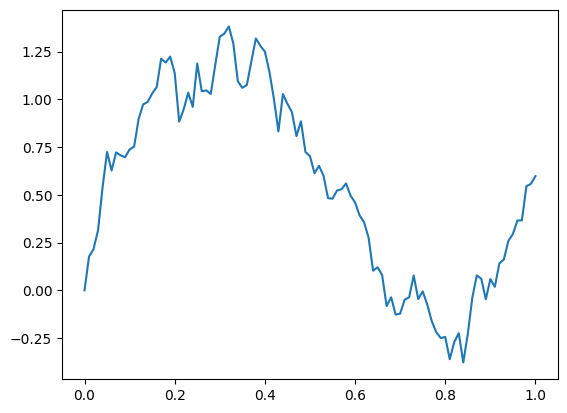

In [ ]:
paths = dataset[0]
plt.plot(np.linspace(0,1,101), paths[0,0])
plt.show()

#### split into a train and val set

In [ ]:
seed = 1
test_size = 0.2
train_idx, val_idx = train_test_split(
        np.arange(dataset_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)

data_train = IrregularDataset(dataset, idx=train_idx)
data_val = IrregularDataset(dataset, idx=val_idx)

#### model training

In [ ]:
_nn = ((50, 'tanh'),)

param_dict_BM = {
    'seed': 2,
    'data_train': data_train,
    'data_val': data_val,
    'dataset_metadata': dataset_metadata,
    'epochs': 6,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 50,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'easy',
    'use_y_for_ode': True,
    'use_rnn': False,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': False,
}

In [ ]:
model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test = train(**param_dict_BM)

using loss: easy
neuralODE use input scaling with tanh
use residual network: input_size=1, output_size=50
use residual network: input_size=50, output_size=1

input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
no variance computation
optimal val-loss (achieved by true cond exp): 0.09785
initiate new model ...

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=53, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
  )
) 

# parameters=7951



40it [00:20,  1.91it/s]

evaluating ...


epoch 1, weight=0.50000, train-loss=0.11401, optimal-val-loss=0.09785, val-loss=0.10197, 
evaluation mean square difference (test set): 0.00010
save new best model: last-best-loss: inf, new-best-loss: 0.10197, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:15,  2.60it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=0.09670, optimal-val-loss=0.09785, val-loss=0.10132, 
evaluation mean square difference (test set): 0.00011
save new best model: last-best-loss: 0.10197, new-best-loss: 0.10132, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:16,  2.48it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=0.10948, optimal-val-loss=0.09785, val-loss=0.09901, 
evaluation mean square difference (test set): 0.00002
save new best model: last-best-loss: 0.10132, new-best-loss: 0.09901, epoch: 3
----------------------------------------------------------------------------------------------------


40it [00:15,  2.66it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=0.10125, optimal-val-loss=0.09785, val-loss=0.09838, 
evaluation mean square difference (test set): 0.00004
save new best model: last-best-loss: 0.09901, new-best-loss: 0.09838, epoch: 4
----------------------------------------------------------------------------------------------------


40it [00:16,  2.47it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=0.10629, optimal-val-loss=0.09785, val-loss=0.09853, 
evaluation mean square difference (test set): 0.00003
----------------------------------------------------------------------------------------------------


40it [00:17,  2.24it/s]

evaluating ...


epoch 6, weight=0.50000, train-loss=0.10053, optimal-val-loss=0.09785, val-loss=0.09858, 
evaluation mean square difference (test set): 0.00003
----------------------------------------------------------------------------------------------------


we can also continue training of the model by passing the trained model to the train function and increasing the number of epochs

In [ ]:
param_dict_BM_1 = copy.deepcopy(param_dict_BM)
param_dict_BM_1['epochs'] = 10
param_dict_BM_1['model'] = model
results = train(**param_dict_BM_1)
model_1 = results[0]


input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
no variance computation
optimal val-loss (achieved by true cond exp): 0.09785

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=53, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
  )
) 

# parameters=7951



40it [00:16,  2.49it/s]

evaluating ...


epoch 7, weight=0.50000, train-loss=0.09887, optimal-val-loss=0.09785, val-loss=0.09893, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: inf, new-best-loss: 0.09893, epoch: 7
----------------------------------------------------------------------------------------------------


40it [00:16,  2.39it/s]

evaluating ...


epoch 8, weight=0.50000, train-loss=0.09441, optimal-val-loss=0.09785, val-loss=0.09867, 
evaluation mean square difference (test set): 0.00003
save new best model: last-best-loss: 0.09893, new-best-loss: 0.09867, epoch: 8
----------------------------------------------------------------------------------------------------


40it [00:16,  2.44it/s]

evaluating ...


epoch 9, weight=0.50000, train-loss=0.09586, optimal-val-loss=0.09785, val-loss=0.09814, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.09867, new-best-loss: 0.09814, epoch: 9
----------------------------------------------------------------------------------------------------


40it [00:16,  2.42it/s]

evaluating ...


epoch 10, weight=0.50000, train-loss=0.09407, optimal-val-loss=0.09785, val-loss=0.09864, 
evaluation mean square difference (test set): 0.00001
----------------------------------------------------------------------------------------------------


#### plot from the trained model

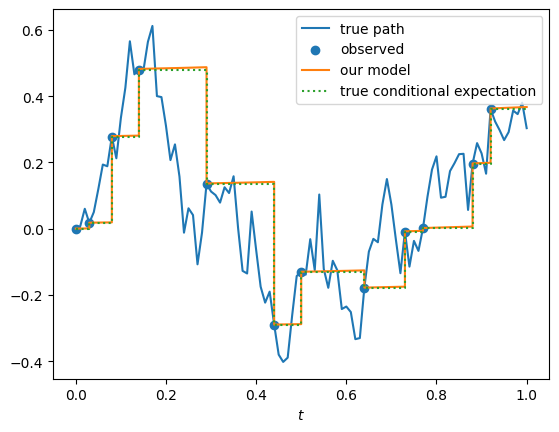

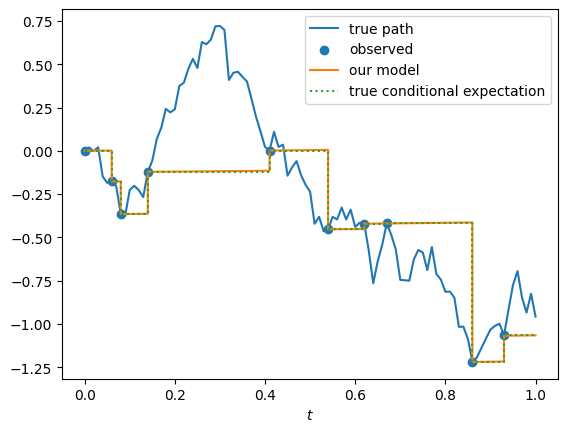

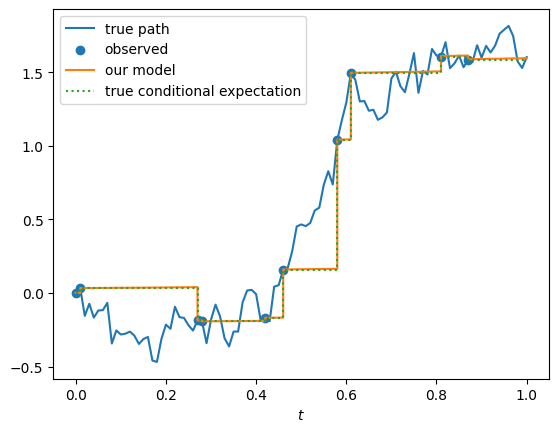

optimal loss (test): 0.09785293041057391
model loss   (test): 0.09857945144176483


In [ ]:
batch = next(iter(dl_test))

opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=model, batch=batch, stockmodel=stockmodel_test,
    delta_t=dataset_metadata["dt"], T=dataset_metadata["maturity"],
    path_to_plot=(0,1,2), reuse_cond_exp=True,)
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

#### Explaination

We see that the model behaves as the conditional expectation, making it explainable. This is implied by the convergence result, which states that the model converges to the conditional expectation in the pseudo metrics
$$ d_k (Z, \xi) =  \mathbb E\left[ \mathbb 1_{\{n \geq k\}} | Z_{t_k-} - \xi_{t_k-} | \right]$$
for any $k \in \mathbb{N}$.
In particular, the model output has to be close to the true conditional expectation at any time where some observation time could be.

Since observation times in this dataset are distributed over the entire time interval, the model consequently approximates the conditional expectation well everywhere.

## On the edge of explainability

In this section we want to train the NJODE model on a dataset, which has a subinterval where no observations are made. This will demonstrate that then it is impossible to learn the correct optimal prediction on this subinterval. Hence, we cannot explain the model output via our standard procedure, i.e., by understanding the conditional expectation there.
However, we regain explainability by analysing the inductive bias of the NJODE model, which basically implies that the model learns the easiest dynamic (i.e., the neural ODE) that describe the training data well.

<a name="inductive-bias"></a>
#### Inductive Bias of NJODE

When training data is limited, many different dynamics can fit the data equally well. Which dynamics does NJODE learn in this case? The choice a learning method makes among equally plausible explanations is known as its *inductive bias*. For NJODEs, this bias tends toward learning the “simplest” dynamics consistent with the data. But what do we mean by *simple*?

We consider a dynamic to be simple if the functions $f_{\theta_1}, \rho_{\theta_2}$, and $g_{\theta_3}$ that define the NJODE are themselves simple. When these functions are parameterized using L2-regularized ReLU neural networks, simplicity can be formalized in terms of a low norm of the second derivative (see [[1](https://arxiv.org/abs/1911.02903),[2](https://arxiv.org/abs/2303.11454),[3](https://arxiv.org/abs/2112.15577),[4](https://epubs.siam.org/doi/10.1137/21M1418642),[5](https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/699241/PhDThesisJakobHeissv1_0_1WithoutCV.pdf?sequence=6&isAllowed=y)] for precise definitions). Under the assumptions of this theoretical work, NJODE tends to learn dynamics that minimize the sum of the second-derivative norms of $f_{\theta_1}, \rho_{\theta_2}$, and $g_{\theta_3}$.

Although these assumptions may not hold exactly in practice, they provide a useful approximation of NJODE’s inductive bias. In essence, NJODEs tend to learn dynamics where the defining functions are as flat and linear as possible, without violating the data (see [[1](https://arxiv.org/abs/1911.02903),[2](https://arxiv.org/abs/2303.11454),[3](https://arxiv.org/abs/2112.15577),[4](https://epubs.siam.org/doi/10.1137/21M1418642),[5](https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/699241/PhDThesisJakobHeissv1_0_1WithoutCV.pdf?sequence=6&isAllowed=y)] for a more nuanced discussion).

With strong regularization (e.g., very early stopping of SGD), NJODEs may even underfit the data in pursuit of simpler functions. Importantly, even when $f_{\theta_1}, \rho_{\theta_2}$, and $g_{\theta_3}$ are linear, NJODE dynamics can still produce nonlinear solutions (e.g., exponential trajectories) [[6](https://openreview.net/pdf?id=0T2OTVCCC1): Example B.1].

#### dataset generation

We generate a dataset which combines Brownian Motions with different drifts. In the first part, there is no drift, then an upward and afterwards the same downward drift and finally no drift again.
If we do not make any observations throughout the two middle parts, then the model cannot learn the correct dynamics there and, a priori, could produce any output in this subinterval. However, the model is biased to learn the easiest function explaining the training data, which would in this case mean that it uses the same dynamics in the middle parts as in the outer parts (since the expectation at the beginning of the last parts is the same as if the entire process was a standard BM without drift).

In [ ]:
BM_outer_part = {
    'model_name': "BM",
    'nb_paths': 10000, 'nb_steps': 25,
    'maturity': 0.25, 'obs_perc': 0.1,
    'dimension': 1, 'drift': 0.,
}
BM_up_part = {
    'model_name': "BM",
    'nb_paths': 10000, 'nb_steps': 25,
    'maturity': 0.25, 'obs_perc': 0.0,
    'dimension': 1, 'drift': 3.,
}
BM_down_part = {
    'model_name': "BM",
    'nb_paths': 10000, 'nb_steps': 25,
    'maturity': 0.25, 'obs_perc': 0.0,
    'dimension': 1, 'drift': -3.,
}

dataset2 = create_combined_dataset(
    stock_model_names=('BM', 'BM', 'BM', 'BM'),
    hyperparam_dicts=(BM_outer_part, BM_up_part, BM_down_part, BM_outer_part),
    seed=0)
dataset_metadata2 = dataset2[-2]

seed = 1
test_size = 0.2
train_idx, val_idx = train_test_split(
        np.arange(dataset_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)

data_train2 = IrregularDataset(dataset2, idx=train_idx)
data_val2 = IrregularDataset(dataset2, idx=val_idx)

#### model training

In [ ]:
param_dict_BM2 = {
    'seed': 2,
    'data_train': data_train2,
    'data_val': data_val2,
    'dataset_metadata': dataset_metadata2,
    'epochs': 6,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 50,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'easy',
    'use_y_for_ode': True,
    'use_rnn': False,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': False,
}

model2, df_metric2, dl2, dl_val2, dl_test2, stockmodel2, stockmodel_test2 = train(**param_dict_BM2)

using loss: easy
neuralODE use input scaling with tanh
use residual network: input_size=1, output_size=50
use residual network: input_size=50, output_size=1

input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
no variance computation
optimal val-loss (achieved by true cond exp): 0.21502
initiate new model ...

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=53, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
  )
) 

# parameters=7951



40it [00:11,  3.62it/s]

evaluating ...


epoch 1, weight=0.50000, train-loss=0.21113, optimal-val-loss=0.21502, val-loss=0.22172, 
evaluation mean square difference (test set): 0.06922
save new best model: last-best-loss: inf, new-best-loss: 0.22172, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:11,  3.62it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=0.23121, optimal-val-loss=0.21502, val-loss=0.21845, 
evaluation mean square difference (test set): 0.06660
save new best model: last-best-loss: 0.22172, new-best-loss: 0.21845, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:11,  3.56it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=0.22343, optimal-val-loss=0.21502, val-loss=0.21908, 
evaluation mean square difference (test set): 0.06160
----------------------------------------------------------------------------------------------------


40it [00:11,  3.61it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=0.20862, optimal-val-loss=0.21502, val-loss=0.21741, 
evaluation mean square difference (test set): 0.06493
save new best model: last-best-loss: 0.21845, new-best-loss: 0.21741, epoch: 4
----------------------------------------------------------------------------------------------------


40it [00:11,  3.62it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=0.19332, optimal-val-loss=0.21502, val-loss=0.21556, 
evaluation mean square difference (test set): 0.05929
save new best model: last-best-loss: 0.21741, new-best-loss: 0.21556, epoch: 5
----------------------------------------------------------------------------------------------------


40it [00:11,  3.57it/s]

evaluating ...


epoch 6, weight=0.50000, train-loss=0.20189, optimal-val-loss=0.21502, val-loss=0.21542, 
evaluation mean square difference (test set): 0.06177
save new best model: last-best-loss: 0.21556, new-best-loss: 0.21542, epoch: 6
----------------------------------------------------------------------------------------------------


#### plot

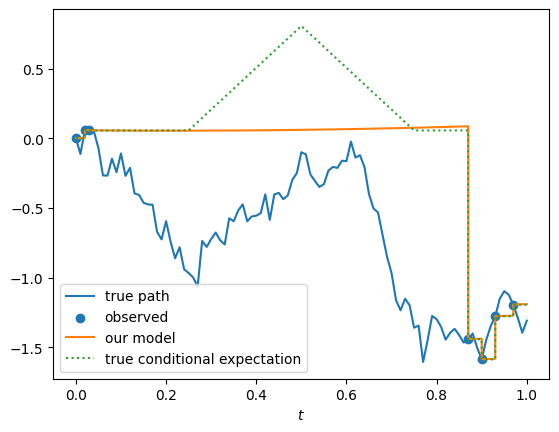

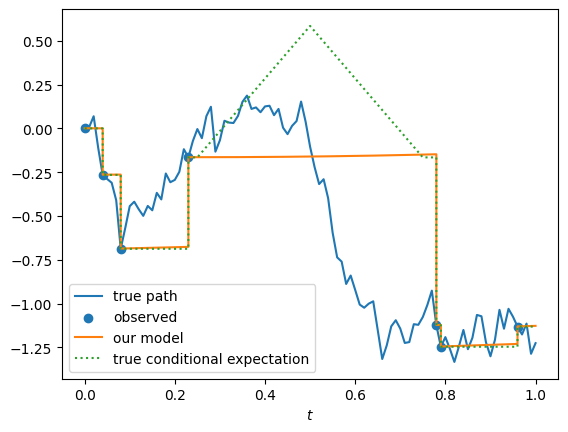

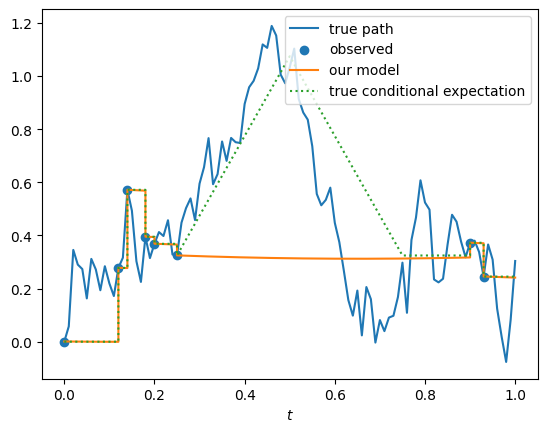

optimal loss (test): 0.215015757146586
model loss   (test): 0.2154196947813034


In [ ]:
batch = next(iter(dl_test2))

opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=model2, batch=batch, stockmodel=stockmodel_test2,
    delta_t=dataset_metadata2["dt"], T=dataset_metadata2["maturity"],
    path_to_plot=(0,1,2), reuse_cond_exp=True,)
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

### **Tasks**:

1. Check that the NJODE recovers the true conditional expectations, if there are observations everywhere. Maybe longer training is needed, to learn this more complex dynamics. Additionally, it can help to use the current time as input for the NNs and to use a different NN architecture. Explain which architecture should be better/worse based on what the NNs need to learn.

2. Play with the datasets and test what the model does in the following scenarios:
  - the inner unobserved subinterval has only an upwards (or downwards) drift
  - the inner unobserved subinterval has a longer (or shorter) period with upwards than downwards drift
  - the inner unobserved subinterval has a stronger (or weaker) upwards than downwards drift    
   
  For all scenarios, first try to understand and predict the behaviour of the model on the unobserved subinterval, arguing with a combination of the **convergence results** and the **inductive bias** of the training.    
  Then train the model and verify whether it behaves as predicted.



## 2 ways to predict the conditional variance

---
**References**:
- for approach 1: [7: Section 5 & Section 8.2](https://arxiv.org/abs/2206.14284), [8: Section 0.4.2.1](https://www.research-collection.ethz.ch/handle/20.500.11850/720717)
- for approach 2: [NJODE website](https://floriankrach.github.io/njode/)

---

The conditional variance can equivalently be written as
$$\text{Var}[X_t | {A}_t] =  \mathbb{E}[(X_t- \mathbb{E}[X_t | {A}_t] )^2 | {A}_t] = \mathbb{E}[X_t^2 | {A}_t] - \mathbb{E}[X_t | {A}_t]^2 , $$
where $A_t$ is the $\sigma$-algebra of the current information.
This allows for 2 ways to learn it via the NJODE model.

1. **Learning the 2nd moment**: The RHS of the equality above suggests to learn to predict the 2nd moment, i.e., $X^2$, additionally to predicting $X$. This can easily be done by a type of data-augmentation, where we focus on learning the process $Z=(X,X^2)$. Once the model is trained to predict Z, the conditional variance prediction with the model output $Y=(Y^1, Y^2)$ is $V_t = Y^2 - (Y^1)^2 \approx \mathbb{E}[X_t^2 | {A}_t] - \mathbb{E}[X_t | {A}_t]^2$.

2. **Learning to predict the conditional variance directly**: The middle expression in the above equality suggest another way to learn the conditional variance. If we first learn to predict $X$ with the model output $Y$, then we can define the process $Z = (X-Y)^2$, which (in the limit) equals $(X_t- \mathbb{E}[X_t | {A}_t] )^2$. Hence, we can learn the conditional variance of $X$, by learning the conditional expectation of $Z$, which amounts to training (a second instance of) the NJODE to predict $Z$.

Both approaches directly extend to learning the conditional covariance in a multi-dimensional setting, by considering the interaction terms. In particular, by replacing $X^2$ and $(X-Y)^2$ by $X^\top X$ and $(X-Y)^\top (X-Y)$, respectively (with the convention that vectors or row-vectors by default). Alternatively, it is also possible to only learn the marginal variances in a multi-dimensional setting, by considering the elementwise powers.

### Pros and cons of the 2 approaches from the perspective of explainability

- Approach 1 seems a bit more straight forward and does not use a NJODE output as part of the target process, like 2 does. Hence, errors cannot accumulate in 1, while this might lead to a bias in the conditional variance prediction of 2.

- However, due to numerical erorrs in the predictions of the 1st and 2nd moment, 1 can lead to conditional variance predictions which do not satisfy its constraints. In particular, non-negativity in the variance case or positive semi-definiteness in the case of learning the conditional covariance.

- Revisiting approach 2, it becomes apparent that this problem can easily be resolved here. Since the target process itself is, by definition/construction, non-negative or positive semi-definite, respectively (importantly, this is true independently of the process $Y$, i.e., even if $Y$ is not perfectly recreating the conditional expectation of $X$), we can also hard-code this into our prediction. In particular, defining the NJODE output (for the variance prediction) as $W$, we can use its square $V=W^2$ or $V=W^\top W$, respectively, as the prediction of the process $Z$, by training the NJODE with the loss $\Psi(Z, V)$.

- In approach 2, we note that $Z_{t-} = (X_{t-} - Y_{t-})^2$ (in the marginal variance case and similar in the covariance matrix case) is in general different from $Z_{t} = (X_{t} - Y_{t})^2$, since they can differ through $Y$ even if $X_t = X_{t-}$. In particular, $Z_{t_i}=0$ if $X_{t_i} \in \mathcal{A}_{t_i}$ (i.e., fully observed), while $Z_{t_i-}$ is in general not $0$. Hence, it is important to use $Z_{t_i}$ and $Z_{t_i-}$, respectively, in the 2 terms of the loss function.

- A priori it seems necessary to sequentially train 2 models for 2, however, both $Y$ and $W$ can be trained simultaneously by adding up their loss functions. When using one joint model for both outputs $Y$ and $W$, the $Y$-term in $Z$  in the loss function $\Psi(Z,V)$ has to be detached from the gradient, so that the variance loss will only optimize the $W$-term but not the $Y$-term (otherwise, the theoretical results might not apply, since the optimization problem changes).

- For both approaches, one can either use two independent NJODE models for the 2 outputs or one joint model. The latter is the most parameter-efficient, since weight-sharing is used, which might lead to beneficial transfer learning effects. However, this might creat a bias through the shared weights, as is always the case when learning more than one output coordinate with the same model.

- Compared to 1, approach 2 has the disadvantage (in the case of full observations) that at/after each observation the conditional variance is $0$ or very close to it. In particular, this means that loss terms become very small, hence, putting less weight on them. Consequently, the variance predictions at and close after observations can suffer from lower relative accuracy. This is reinforced by taking the square of the model output. In particular, if $W$ is close to $0$, then the square will be even closer to $0$, meaning that it is harder for the model to learn to output exactly $0$.
In contrast to this, approach 1 does, in general, not have this problem, since the 2nd moment doesn't jump to $0$ at observations.

Overall, approach 2 is preferable, whenever it is important that the constraints are always satisfied. Moreover, we will see how the cons of approach 2 can be mitigated or resolved (considering the inductive bias of the model), such that it fully outperforms approach 1.

### Comparing the approaches in action

#### Approach 1: predicting 1st and 2nd moment

In [ ]:
BM_dict_U = {
    'model_name': "BM",
    'nb_paths': 10000, 'nb_steps': 100,
    'maturity': 1., 'obs_perc': 0.1,
    'dimension': 1,
}

dataset = create_dataset(BM_dict_U["model_name"], BM_dict_U, seed=0)
dataset_metadata = dataset[-2]

seed = 1
test_size = 0.2
train_idx, val_idx = train_test_split(
        np.arange(dataset_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)
data_train = IrregularDataset(dataset, idx=train_idx)
data_val = IrregularDataset(dataset, idx=val_idx)

_nn = ((50, 'relu'),)
param_dict_BM = {
    'seed': 2,
    'data_train': data_train,
    'data_val': data_val,
    'dataset_metadata': dataset_metadata,
    'epochs': 6,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 50,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'easy',
    'use_y_for_ode': True,
    'use_rnn': False,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': False,
    'func_appl_X': ["power-2"],
}

# results = [model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test]
results = train(**param_dict_BM)

<ipython-input-9-0f75a0232095>:199: UserWarning: function application to X and concurrent variance/covariance computation might lead to problems! Use carefully!
  warnings.warn(


using loss: easy
neuralODE use input scaling with tanh
use residual network: input_size=2, output_size=50
use residual network: input_size=50, output_size=2

input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
apply functions to X
new input_coords: [0 1]
new output_coords: [0 1]
no variance computation
optimal (corrected: only original X used) val-loss (achieved by true cond exp): 0.09785
initiate new model ...

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=54, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
     

40it [00:16,  2.36it/s]

evaluating ...


epoch 1, weight=0.50000, train-loss=0.33213, optimal-val-loss=0.09785, val-loss=0.28706, 
evaluation mean square difference (test set): 0.00007
save new best model: last-best-loss: inf, new-best-loss: 0.28706, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:17,  2.28it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=0.31969, optimal-val-loss=0.09785, val-loss=0.28296, 
evaluation mean square difference (test set): 0.00009
save new best model: last-best-loss: 0.28706, new-best-loss: 0.28296, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:16,  2.43it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=0.30856, optimal-val-loss=0.09785, val-loss=0.27996, 
evaluation mean square difference (test set): 0.00007
save new best model: last-best-loss: 0.28296, new-best-loss: 0.27996, epoch: 3
----------------------------------------------------------------------------------------------------


40it [00:17,  2.34it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=0.23412, optimal-val-loss=0.09785, val-loss=0.27966, 
evaluation mean square difference (test set): 0.00002
save new best model: last-best-loss: 0.27996, new-best-loss: 0.27966, epoch: 4
----------------------------------------------------------------------------------------------------


40it [00:17,  2.32it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=0.25921, optimal-val-loss=0.09785, val-loss=0.27832, 
evaluation mean square difference (test set): 0.00002
save new best model: last-best-loss: 0.27966, new-best-loss: 0.27832, epoch: 5
----------------------------------------------------------------------------------------------------


40it [00:17,  2.26it/s]

evaluating ...


epoch 6, weight=0.50000, train-loss=0.27805, optimal-val-loss=0.09785, val-loss=0.27853, 
evaluation mean square difference (test set): 0.00002
----------------------------------------------------------------------------------------------------


4


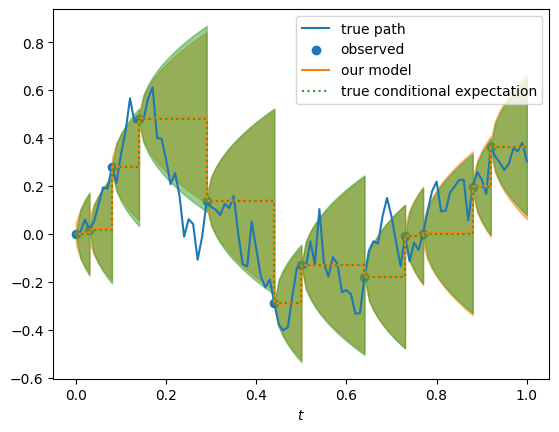

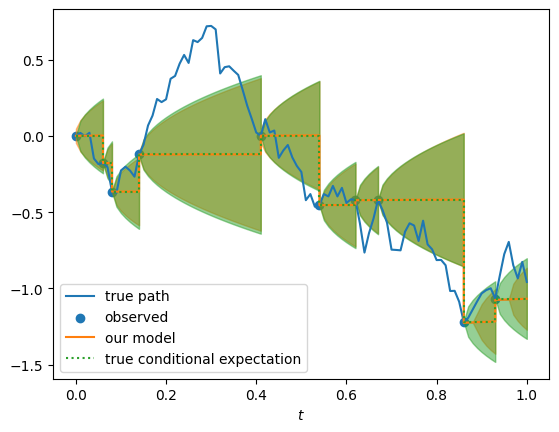

optimal loss (test): 0.09785293041057391
model loss   (test): 0.2785286605358124


In [ ]:
# plotting
batch = next(iter(results[4]))

opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=results[0], batch=batch, stockmodel=results[-1],
    delta_t=dataset_metadata["dt"], T=dataset_metadata["maturity"],
    path_to_plot=(0,1), reuse_cond_exp=False,
    plot_variance=True, plot_true_var=True,
    functions=["power-2"])
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

From the warning and in the 2nd plot at $t \approx 0.85$ we see that the conditional variance is not everywhere positive, due to numerical errors in this early stage of training. With longer training, this will not happen anymore in this relatively easy dataset.

#### Approach 2: predicting the conditional variance directly

In [ ]:
BM_dict_U = {
    'model_name': "BM",
    'nb_paths': 10000, 'nb_steps': 100,
    'maturity': 1., 'obs_perc': 0.1,
    'dimension': 1,
}

dataset = create_dataset(BM_dict_U["model_name"], BM_dict_U, seed=0)
dataset_metadata = dataset[-2]

seed = 1
test_size = 0.2
train_idx, val_idx = train_test_split(
        np.arange(dataset_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)
data_train = IrregularDataset(dataset, idx=train_idx)
data_val = IrregularDataset(dataset, idx=val_idx)

_nn = ((50, 'relu'),)
param_dict_BM = {
    'seed': 2,
    'data_train': data_train,
    'data_val': data_val,
    'dataset_metadata': dataset_metadata,
    'epochs': 6,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 50,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'easy',
    'use_y_for_ode': True,
    'use_rnn': False,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': True,
    'var_weight': 1,
}

# results = [model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test]
results1 = train(**param_dict_BM)

<ipython-input-64-0f75a0232095>:252: UserWarning: optimal loss might be wrong, since the conditional variance is also learned, which is not accounted for in computation of the optimal loss
  warnings.warn(


using loss: easy
using variance loss weight: 1
neuralODE use input scaling with tanh
use residual network: input_size=1, output_size=50
use residual network: input_size=50, output_size=2

input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
compute (marginal) variance of size 1
optimal val-loss (achieved by true cond exp): 0.09785
initiate new model ...

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=53, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=50, out_features=2, bias=True)
    

40it [00:22,  1.75it/s]

evaluating ...


epoch 1, weight=0.50000, train-loss=0.16518, optimal-val-loss=0.09785, val-loss=0.14575, 
evaluation mean square difference (test set): 0.00007
save new best model: last-best-loss: inf, new-best-loss: 0.14575, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:22,  1.78it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=0.16894, optimal-val-loss=0.09785, val-loss=0.13751, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.14575, new-best-loss: 0.13751, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:22,  1.82it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=0.12501, optimal-val-loss=0.09785, val-loss=0.13667, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.13751, new-best-loss: 0.13667, epoch: 3
----------------------------------------------------------------------------------------------------


40it [00:22,  1.78it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=0.16049, optimal-val-loss=0.09785, val-loss=0.13605, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.13667, new-best-loss: 0.13605, epoch: 4
----------------------------------------------------------------------------------------------------


40it [00:20,  1.91it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=0.18994, optimal-val-loss=0.09785, val-loss=0.13541, 
evaluation mean square difference (test set): 0.00000
save new best model: last-best-loss: 0.13605, new-best-loss: 0.13541, epoch: 5
----------------------------------------------------------------------------------------------------


40it [00:44,  1.10s/it]

evaluating ...


epoch 6, weight=0.50000, train-loss=0.13797, optimal-val-loss=0.09785, val-loss=0.13532, 
evaluation mean square difference (test set): 0.00009
save new best model: last-best-loss: 0.13541, new-best-loss: 0.13532, epoch: 6
----------------------------------------------------------------------------------------------------


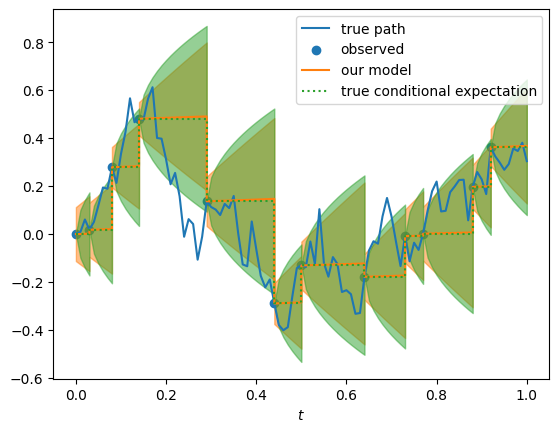

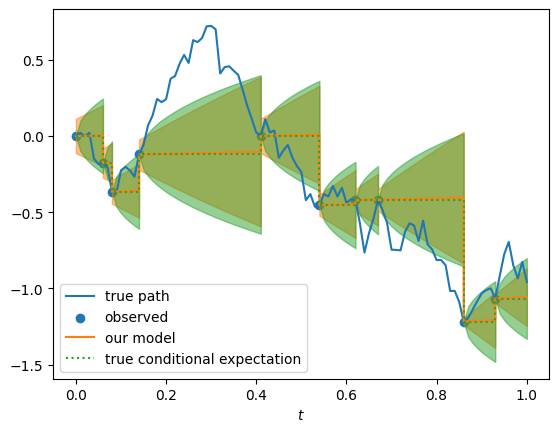

optimal loss (test): 0.09785293041057391
model loss   (test): 0.13531622290611267


In [ ]:
# plotting
batch = next(iter(results1[4]))

opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=results1[0], batch=batch, stockmodel=results1[-1],
    delta_t=dataset_metadata["dt"], T=dataset_metadata["maturity"],
    path_to_plot=(0,1), reuse_cond_exp=False,
    plot_variance=True, plot_true_var=True)
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

We see that the the variance predictions at observations are not 0 (hence, too large) and shortly after observations are too small.
However, we **never get negative predictions in contrast to the 1. approach**.

**Explanation**: The inductive bias of this approach is that the dynamics of the standard deviation (which is plotted) is a simple function. By choosing a constant, the resulting standard deviation is a linear function of time, which is approximately the behaviour we see.


#### Improving predictions of approach 2

To improve the predictions of the variance we can:
- *Put more weight on the variance loss*: As explained before, approach 2 has the disadvantage that variance loss terms at observations are small (since close to 0 and squared), hence, the model is not forced so strongly to learn to jump to 0 with the variance prediction. By putting more weight on the variance loss term, we can enforce this more strongly.
- *Use deeper / more complex NNs*: Since the functions to learn are complex (the neuralODE needs to learn the derivative of the square root of $Δ_t = t - \tau(t)$), we need flexible enough NNs to be able to approximate this function.
- *Train longer*: learning more complex functions with more complex NNs also takes longer, hence, increase the number of epochs.

More sophisticated improvements through considerations of the inductive bias:
- *Add $1/\sqrt{\Delta_t}$ as input to neuralODE*: The neuralODE has to learn the time derivative of $\sqrt{\Delta_t}$, which is $\propto 1/\sqrt{\Delta_t}$. The main problem in learning this is that it is $\infty$ at $\Delta_t=0$, hence, it has unbounded 2nd derivative. Therefore, this has a very bad inductive bias to be learnt; it can only be approximated if the NNs are trained well enough with enough good data samples, but it can never be perfectly replicated. However, by passing the term to the function as input, we drastically improve the inductive bias, since now it only needs to learn the identity. This is an easy function to learn with $0$ 2nd derivative. Hence, it should now be easy for the NN to learn this.

We start by only using the first 3 points for improvement, without the more sophisticated considerations.

In [ ]:
BM_dict_U = {
    'model_name': "BM",
    'nb_paths': 10000, 'nb_steps': 100,
    'maturity': 1., 'obs_perc': 0.1,
    'dimension': 1,
}

dataset = create_dataset(BM_dict_U["model_name"], BM_dict_U, seed=0)
dataset_metadata = dataset[-2]

seed = 1
test_size = 0.2
train_idx, val_idx = train_test_split(
        np.arange(dataset_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)
data_train = IrregularDataset(dataset, idx=train_idx)
data_val = IrregularDataset(dataset, idx=val_idx)

_nn = ((50, 'relu'),(50, 'relu'))
param_dict_BM = {
    'seed': 2,
    'data_train': data_train,
    'data_val': data_val,
    'dataset_metadata': dataset_metadata,
    'epochs': 10,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 50,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'easy',
    'use_y_for_ode': True,
    'use_rnn': False,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': True,
    'var_weight': 10,
}

# results = [model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test]
results2 = train(**param_dict_BM)

<ipython-input-9-0f75a0232095>:252: UserWarning: optimal loss might be wrong, since the conditional variance is also learned, which is not accounted for in computation of the optimal loss
  warnings.warn(


using loss: easy
using variance loss weight: 10
neuralODE use input scaling with tanh
use residual network: input_size=1, output_size=50
use residual network: input_size=50, output_size=2

input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
compute (marginal) variance of size 1
optimal val-loss (achieved by true cond exp): 0.09785
initiate new model ...

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=53, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)


40it [00:27,  1.48it/s]

evaluating ...


epoch 1, weight=0.50000, train-loss=0.52457, optimal-val-loss=0.09785, val-loss=0.48920, 
evaluation mean square difference (test set): 0.00010
save new best model: last-best-loss: inf, new-best-loss: 0.48920, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:24,  1.62it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=0.88279, optimal-val-loss=0.09785, val-loss=0.47220, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.48920, new-best-loss: 0.47220, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:23,  1.68it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=0.55403, optimal-val-loss=0.09785, val-loss=0.45841, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.47220, new-best-loss: 0.45841, epoch: 3
----------------------------------------------------------------------------------------------------


40it [00:24,  1.63it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=0.62833, optimal-val-loss=0.09785, val-loss=0.45214, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.45841, new-best-loss: 0.45214, epoch: 4
----------------------------------------------------------------------------------------------------


40it [00:24,  1.63it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=0.48079, optimal-val-loss=0.09785, val-loss=0.44831, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.45214, new-best-loss: 0.44831, epoch: 5
----------------------------------------------------------------------------------------------------


40it [00:24,  1.61it/s]

evaluating ...


epoch 6, weight=0.50000, train-loss=0.55508, optimal-val-loss=0.09785, val-loss=0.44981, 
evaluation mean square difference (test set): 0.00002
----------------------------------------------------------------------------------------------------


40it [00:24,  1.63it/s]

evaluating ...


epoch 7, weight=0.50000, train-loss=0.44637, optimal-val-loss=0.09785, val-loss=0.44691, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.44831, new-best-loss: 0.44691, epoch: 7
----------------------------------------------------------------------------------------------------


40it [00:28,  1.38it/s]

evaluating ...


epoch 8, weight=0.50000, train-loss=0.43618, optimal-val-loss=0.09785, val-loss=0.44795, 
evaluation mean square difference (test set): 0.00001
----------------------------------------------------------------------------------------------------


40it [00:37,  1.08it/s]

evaluating ...


epoch 9, weight=0.50000, train-loss=0.45510, optimal-val-loss=0.09785, val-loss=0.44822, 
evaluation mean square difference (test set): 0.00005
----------------------------------------------------------------------------------------------------


40it [00:27,  1.44it/s]

evaluating ...


epoch 10, weight=0.50000, train-loss=0.95510, optimal-val-loss=0.09785, val-loss=0.44648, 
evaluation mean square difference (test set): 0.00001
save new best model: last-best-loss: 0.44691, new-best-loss: 0.44648, epoch: 10
----------------------------------------------------------------------------------------------------


4


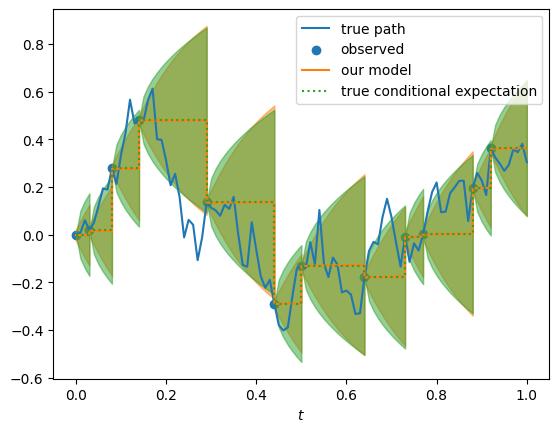

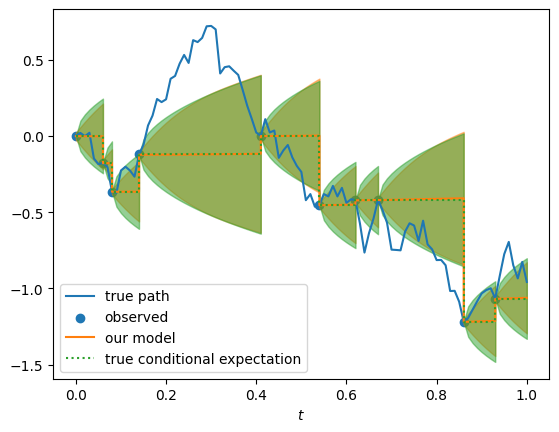

optimal loss (test): 0.09785293041057391
model loss   (test): 0.44648197293281555


In [ ]:
# plotting
batch = next(iter(results2[4]))

opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=results2[0], batch=batch, stockmodel=results2[-1],
    delta_t=dataset_metadata["dt"], T=dataset_metadata["maturity"],
    path_to_plot=(0,1), reuse_cond_exp=False,
    plot_variance=True, plot_true_var=True)
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

We see that the larger model with longer training and more weight on the variance loss improved the variance predictions considerably.
In particular, the predictions at observation times are (very close to) 0 and the predicted standard deviation curve is quite close to the true one (i.e., $\sqrt{\Delta_t}$).
Longer training and even larger models should further improve the results.



#### More Sophisticated improvement of approach 2

In [ ]:
BM_dict_U = {
    'model_name': "BM",
    'nb_paths': 10000, 'nb_steps': 100,
    'maturity': 1., 'obs_perc': 0.1,
    'dimension': 1,
}

dataset = create_dataset(BM_dict_U["model_name"], BM_dict_U, seed=0)
dataset_metadata = dataset[-2]

seed = 1
test_size = 0.2
train_idx, val_idx = train_test_split(
        np.arange(dataset_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)
data_train = IrregularDataset(dataset, idx=train_idx)
data_val = IrregularDataset(dataset, idx=val_idx)

_nn = ((50, 'relu'),(50, 'relu'))
param_dict_BM = {
    'seed': 2,
    'data_train': data_train,
    'data_val': data_val,
    'dataset_metadata': dataset_metadata,
    'epochs': 10,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 50,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'easy',
    'use_y_for_ode': True,
    'use_rnn': False,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': True,
    'var_weight': 10,
    'input_var_t_helper': True,
}

# results = [model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test]
results3 = train(**param_dict_BM)

<ipython-input-22-ee36952e0e23>:256: UserWarning: optimal loss might be wrong, since the conditional variance is also learned, which is not accounted for in computation of the optimal loss
  warnings.warn(


using loss: easy
using variance loss weight: 10
neuralODE use input scaling with tanh
use residual network: input_size=1, output_size=50
use residual network: input_size=50, output_size=2

input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
compute (marginal) variance of size 1
optimal val-loss (achieved by true cond exp): 0.09785
initiate new model ...

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=54, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)


40it [00:45,  1.14s/it]

evaluating ...


epoch 1, weight=0.50000, train-loss=0.47061, optimal-val-loss=0.09785, val-loss=0.45139, 
evaluation mean square difference (test set): 0.00011
save new best model: last-best-loss: inf, new-best-loss: 0.45139, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:35,  1.14it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=0.49461, optimal-val-loss=0.09785, val-loss=0.45080, 
evaluation mean square difference (test set): 0.00010
save new best model: last-best-loss: 0.45139, new-best-loss: 0.45080, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:27,  1.44it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=0.65598, optimal-val-loss=0.09785, val-loss=0.45248, 
evaluation mean square difference (test set): 0.00008
----------------------------------------------------------------------------------------------------


40it [00:29,  1.38it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=0.45205, optimal-val-loss=0.09785, val-loss=0.45132, 
evaluation mean square difference (test set): 0.00013
----------------------------------------------------------------------------------------------------


40it [00:26,  1.52it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=0.56460, optimal-val-loss=0.09785, val-loss=0.45441, 
evaluation mean square difference (test set): 0.00014
----------------------------------------------------------------------------------------------------


40it [00:26,  1.52it/s]

evaluating ...


epoch 6, weight=0.50000, train-loss=0.60119, optimal-val-loss=0.09785, val-loss=0.44992, 
evaluation mean square difference (test set): 0.00008
save new best model: last-best-loss: 0.45080, new-best-loss: 0.44992, epoch: 6
----------------------------------------------------------------------------------------------------


40it [00:26,  1.51it/s]

evaluating ...


epoch 7, weight=0.50000, train-loss=0.76143, optimal-val-loss=0.09785, val-loss=0.44845, 
evaluation mean square difference (test set): 0.00007
save new best model: last-best-loss: 0.44992, new-best-loss: 0.44845, epoch: 7
----------------------------------------------------------------------------------------------------


40it [00:27,  1.48it/s]

evaluating ...


epoch 8, weight=0.50000, train-loss=0.61643, optimal-val-loss=0.09785, val-loss=0.44947, 
evaluation mean square difference (test set): 0.00007
----------------------------------------------------------------------------------------------------


40it [00:25,  1.55it/s]

evaluating ...


epoch 9, weight=0.50000, train-loss=0.48693, optimal-val-loss=0.09785, val-loss=0.44836, 
evaluation mean square difference (test set): 0.00004
save new best model: last-best-loss: 0.44845, new-best-loss: 0.44836, epoch: 9
----------------------------------------------------------------------------------------------------


40it [00:25,  1.55it/s]

evaluating ...


epoch 10, weight=0.50000, train-loss=0.53323, optimal-val-loss=0.09785, val-loss=0.44758, 
evaluation mean square difference (test set): 0.00006
save new best model: last-best-loss: 0.44836, new-best-loss: 0.44758, epoch: 10
----------------------------------------------------------------------------------------------------


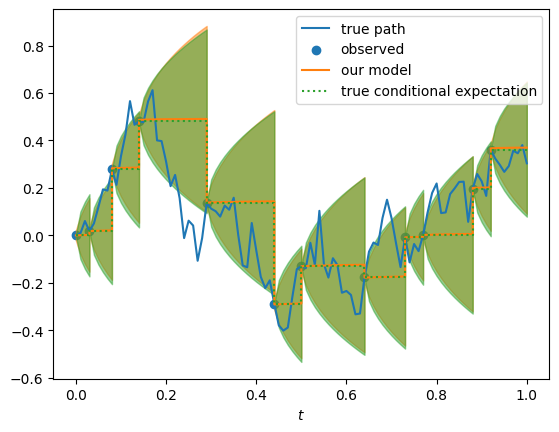

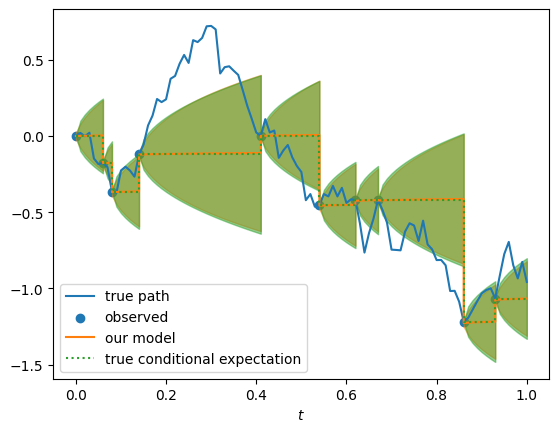

optimal loss (test): 0.09785293041057391
model loss   (test): 0.4475751519203186


In [ ]:
# plotting
batch = next(iter(results3[4]))

opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=results3[0], batch=batch, stockmodel=results3[-2],
    delta_t=dataset_metadata["dt"], T=dataset_metadata["maturity"],
    path_to_plot=(0,1), reuse_cond_exp=False,
    plot_variance=True, plot_true_var=True)
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

**Explanation**: As expected, now the model replicates the conditional standard deviation nearly perfectly, since it has a good inductive bias for learning it.

Even though this fix of the inductive bias is somewhat specifically designed for the considered BM example, the model will benefit from this architectural improvement also when applied to many other datasets. In particular, whenever the conditional distribution is approximately normal, this will help to better capture the conditional variance. Moreover, any dependence on the inverse of $\Delta_t$ can be approximated much more easily like this.
For datasets where this is not enough, additional feature engineering to provide good features for approximating the conditional variance more easily can be helpful.

### **Tasks**:

We saw that using the sophisticated improvements on top of the others resolves all initial issues of approach 2. A natural question that arises is, whether the sophistiated improvement alone, without the previous 3 tweaks for improvement, is enough? Or whether some or all of them are necessary to make  approach 2 work so well?

First answer this question based on arguments of explainability. Then train (a) model(s) to verify your prediction.

## Dealing with noisy observations

---
**References**:
- the paper [6](https://openreview.net/pdf?id=0T2OTVCCC1)
---

Here we consider the situation, where we do not observe the process $X$ directly at observation times, but with additional additive noise, leading to observations $O_{t_i} = X_{t_i} + ϵ_{i}$, where $ϵ_i$ are iid., mean $0$ noise terms independent of $X$. Even though we make noisy observations, we still want to predict the process $X$, filtering the noise.

Revisiting our loss function
$$\Psi(\xi, \zeta) := \mathbb{E}\left[ \frac{1}{n} \sum_{i=1}^n \left(  \left\lvert M_i \odot \left( \xi_{t_i} - \zeta_{t_i} \right) \right\rvert_2 + \left\lvert M_i \odot \left( \xi_{t_i-} - \zeta_{t_{i}-} \right) \right\rvert_2 \right)^2 \right], $$
it becomes apparent that the first term will push the model to jump to the noisy observations to minimize this term, instead of filtering out the noise.

On the other hand, the second loss term has the minimizer
$$\mathbb{E}[O_{t_i-} | A_{t_i-}] = \mathbb{E}[X_{t_i-} + ϵ_i | A_{t_i-}] = \mathbb{E}[X_{t_i-} | A_{t_i-}],$$
where $A_{t_i-}$ now carries the information of the past noisy observations $O_{t_j}$, $j<i$.
Hence, learning the optimizer of the 2nd term yields the conditional expectation of the target process $X$, where the noise was filtered out.

In a setting where the next observation can be at any time after the previous one, the 2nd term alone is enough to learn the conditional expectation. Indeed, if the prediction doesn't jump correctly (correctly here means not to the noisy observation, but to the filtered signal, i.e., the conditional expectation of $X$), predictions closely afterwards will be off. The only way to mitigate this is by very quickly correcting this wrong jump, which yield functions with large 2nd derivative. Hence, the model's inductive bias to learn functions with minimal 2nd derivative, pushes the model to learn the correct jump and therefore the conditional expectation of $X$ at observation, even without a loss term directly forcing the model to do so.

Consequently, we define the **noise-adapted** loss function as
$$\Psi_{\text{noise}}(\xi, \zeta) := \mathbb{E}\left[ \frac{1}{n} \sum_{i=1}^n \left\lvert M_i \odot \left( \xi_{t_i-} - \zeta_{t_{i}-} \right) \right\rvert_2^2 \right]. $$



### Training a NJODE model with the noise adapted loss function

In the following, we use a BM dataset with iid. additive Gaussian observation noise and train a NJODE model with the noise-adapted loss function.

We note that the resulting model is not Markovian, hence, we need to use a path-dependent NJODE architecture (by using an RNN or by including the signature transform as input).

In [ ]:
BM_NoisyObs = {
    'model_name': "BMNoisyObs",
    'nb_paths': 10000, 'nb_steps': 100,
    'maturity': 1., 'obs_perc': 0.1,
    'dimension': 1,
    'obs_noise': {'distribution': 'normal', 'scale': 0.5, 'loc': 0.,
                  'noise_at_start': False},
}

dataset = create_dataset(BM_NoisyObs["model_name"], BM_NoisyObs, seed=0)
dataset_metadata = dataset[-2]

seed = 1
test_size = 0.2
train_idx, val_idx = train_test_split(
        np.arange(dataset_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)
data_train = IrregularDataset(dataset, idx=train_idx)
data_val = IrregularDataset(dataset, idx=val_idx)

_nn = ((50, 'relu'),)
param_dict_BM_Noise = {
    'seed': 2,
    'data_train': data_train,
    'data_val': data_val,
    'dataset_metadata': dataset_metadata,
    'epochs': 6,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 50,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'noisy_obs',
    'use_y_for_ode': True,
    'use_rnn': True,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': False,
}

# results = [model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test]
results = train(**param_dict_BM_Noise)

using loss: noisy_obs
neuralODE use input scaling with tanh
use residual network: input_size=1, output_size=50
use residual network: input_size=50, output_size=1

input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
no variance computation
optimal val-loss (achieved by true cond exp): 0.43568
initiate new model ...

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=53, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=51, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
  )
) 

# parameters=10451



40it [00:18,  2.18it/s]

evaluating ...


epoch 1, weight=0.50000, train-loss=0.44953, optimal-val-loss=0.43568, val-loss=0.44462, 
evaluation mean square difference (test set): 0.01115
save new best model: last-best-loss: inf, new-best-loss: 0.44462, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:25,  1.55it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=0.44460, optimal-val-loss=0.43568, val-loss=0.44215, 
evaluation mean square difference (test set): 0.00771
save new best model: last-best-loss: 0.44462, new-best-loss: 0.44215, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:20,  1.96it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=0.45385, optimal-val-loss=0.43568, val-loss=0.44157, 
evaluation mean square difference (test set): 0.00669
save new best model: last-best-loss: 0.44215, new-best-loss: 0.44157, epoch: 3
----------------------------------------------------------------------------------------------------


40it [00:21,  1.90it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=0.43321, optimal-val-loss=0.43568, val-loss=0.44012, 
evaluation mean square difference (test set): 0.00527
save new best model: last-best-loss: 0.44157, new-best-loss: 0.44012, epoch: 4
----------------------------------------------------------------------------------------------------


40it [00:20,  1.93it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=0.42500, optimal-val-loss=0.43568, val-loss=0.43901, 
evaluation mean square difference (test set): 0.00411
save new best model: last-best-loss: 0.44012, new-best-loss: 0.43901, epoch: 5
----------------------------------------------------------------------------------------------------


40it [00:23,  1.73it/s]

evaluating ...


epoch 6, weight=0.50000, train-loss=0.43677, optimal-val-loss=0.43568, val-loss=0.43815, 
evaluation mean square difference (test set): 0.00334
save new best model: last-best-loss: 0.43901, new-best-loss: 0.43815, epoch: 6
----------------------------------------------------------------------------------------------------


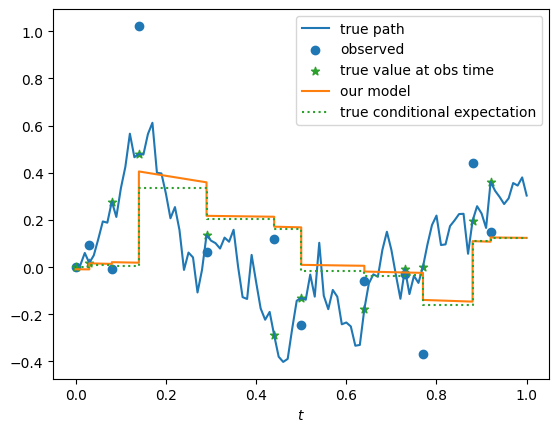

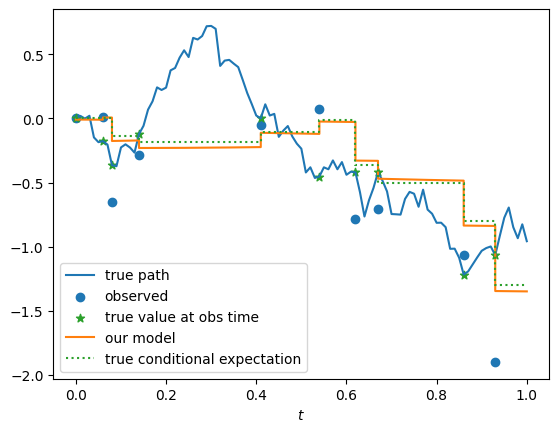

optimal loss (test): 0.43568044628865743
model loss   (test): 0.43814733624458313


In [ ]:
# plotting
batch = next(iter(results[4]))

opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=results[0], batch=batch, stockmodel=results[-1],
    delta_t=dataset_metadata["dt"], T=dataset_metadata["maturity"],
    path_to_plot=(0,1), reuse_cond_exp=False,
    plot_variance=False, plot_true_var=False,
    which_loss='noisy_obs',)
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

Already after short training, we see that the model captures the correct behaviour and manages to filter out the observation noise well.

### **Tasks**:

What happens when the NJODE model is trained on this dataset with the standard loss function? First use arguments of explainability (convergence results and inductive bias of the model) to predict the behaviour. Then verify your predictions by training the corresponding model.

### When to use the noise adapted loss function?

The noise adapted loss function can be used for training on datasets where  observations have an additional additive noise term. However, this clearly also applies in the case that the additive noise is $0$, i.e., in the standard setting of the NJODE. Hence, the question arises, whether we should also use the noise adapted loss function in the standard setting without observation noise, which would make the standard loss function obsolete.



### **Task**

Answer the question first with arguments of explainability and inductive bias.
Then train the same model once with the standard and once with the noise adapted loss function on a dataset without observation noise, to verify your claims.

## Why long-term predictions do not work and how to fix this

---
**References**:
- the paper [9](https://arxiv.org/abs/2407.18808)
---

The NJODE model, as presented so far, approximates the conditional expectation of the target process $X$ at any time $t$ given all information available up to time $t$, i.e., $\hat X_t = \mathbb{E}[X_t | A_t]$.
In contrast to this, we refer to long term predictions when we want are interested in the conditional expectation of the target process $X$ at any time $t$ given only the information available up to some time $s < t$, i.e., $\hat X_{t,s} = \mathbb{E}[X_t | A_{s ∧ t}]$.



### Understanding why long term predictions do not work
Training the model in the standard way to learn $\hat X_t$, in principle learns the dynamics through the neuralODE, which could also be applied for longer prediction horizons. Indeed, if the neuralODE perfectly replicates the dynamics of the process, and if those dynamics are not time-dependent, then this should, in principle, lead to the correct predictions.
However, in practice, the neuralODE will only approximate the dynamics as good as it needs to explain the training data well, while its inductive bias bias is to use the simples functions to do this. Moreover, the approximation is only guaranteed to be good within the compact region that it sees during training. Using inputs outside of this region (i.e., larger times or time-differences in the present case) can lead to unpredictable behaviour. Furthermore, integrating the neuralODE over a longer time horizons than usually done in training, can lead to large errors if the neuralODE only leads to good approximations for the shorter time horizons seen during training.

### **Task**

Verify that long term predictions do not work, even on a dataset with simple dynamics, when then model does not learn to predict far ahead on the training set (i.e., observations are never far apart).

To do this, first generate a training and validation set with high observation probability (so that observations are always relatively close together) and a test set with very small (or $0$) observation probability (so that long term predictions have to be produced, wrt. the distribution of the training set).
Then train a NJODE model and evaluate it on the validation and the test set. On the validation set we should see that the model learned the dynamics of the training data distribution well (as a check), while on the test set the predictions might not work well.

Do this in the following cases of increasing complexity of the dynamics. In each case, first predict with arguments of explainability and inductive bias  what you expect to see, then verify this by training the model. The dataset models are:
1. $X$ is a Brownian Motion (BM)
2. $X$ is a BM with drift
3. $X$ is a geometric BM, i.e., a Black-Scholes model.


### How to learn long term predictions

The problem, why the model does not generalise well for longer time horizons than seen in the training set, is that it never had to do this during training. In particular, it was never forced to to produce good predictions over longer time horizons through a corresponding loss term.

Vice versa, if we trained the model also with longer time intervals between observations, then we would expect it to learn the correct dynamics for this longer time horizon well.
This consideration reveals a very easy way how to learn long term predictions. In particular, we only need to augment the training dataset such that there are longer time intervals without observations. An easy way to do this is by randomly masking out observation times, which wil lead to a dataset with larger gaps between observations.
There are several considerations for doing this in a structured and data-efficient way:
- We can e.g. choose to mask observation times using iid. Bernoulli random variables with a probability $p \in (0,1)$. By doing this "on the fly", we can mask out different observations in each of the training epochs, hence, not losing the information of these datapoints completely. This will give a lot of differently looking datasets in each epoch.
- Instead of Bernoulli RVs for each observation time one can also sample expontantial RVs for the minimal time gap without observation after each observation. This will more directly lead to longer gaps between observations. However, in the following explanations we stick to Bernoulli RVs.
- Theoretically, any $p \in (0,1)$ will lead to a positive probability of deleting/masking out any wanted finitely many observations, so in the limit they all lead to perfect long term predictions. However, practically the choice of $p$ can strongly influence what the model actually gets to see during training. Hence, an easy way to deal with this hyperparameter selection, is to start with $p=1$ (no masking at all) and continuously decresing $p$ with the epochs to some small target value $p_{\text{end}} > 0$. This way, the model should jointly learn the short and long term predictions well and also learns the jumps correctly (with $p\approx 0$, the model never needs to jump, hence will not learn this).
- Instead of masking out the observation times completely, we can actually use the data more efficiently, which should lead to faster convergence. Masking out observations would mean that we also do not use these observations in the loss function as the target that the model should predict. However, since we already have this information, it would be inefficient not to use it. Therefore, instead of masking out observations, one should only mask them out as inputs to the model (i.e., not use them as input), while still using them in the loss function (as the target to be predicted). This makes the model learn the same long term term predictions, however, with a stronger feedback from the loss function for faster convergence.

These considerations lead to a training framework adapted for learning long term predictions.

#### Long term predictions on geometric BM

We reuse the dataset from task 3 and train the NJODE model with the adapted training framework for long term predictions, where $p$ decreases with the epochs of training.

In [ ]:
BS_LT_dict = {
    'model_name': "BlackScholes",
    'drift': 2., 'volatility': 0.3,
    'nb_paths': 10000, 'nb_steps': 100,
    'S0': 1, 'maturity': 1., 'dimension': 1,
    'obs_perc': 0.4,
}
BS_LT_dict_test = {
    'model_name': "BlackScholes",
    'drift': 2., 'volatility': 0.3,
    'nb_paths': 4000, 'nb_steps': 100,
    'S0': 1, 'maturity': 1., 'dimension': 1,
    'obs_perc': 0.005,
}

dataset = create_dataset(BS_LT_dict["model_name"], BS_LT_dict, seed=0)
dataset_metadata = dataset[-2]
seed = 1
test_size = 0.2
train_idx, val_idx = train_test_split(
        np.arange(dataset_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)
data_train = IrregularDataset(dataset, idx=train_idx)
data_val = IrregularDataset(dataset, idx=val_idx)
dataset_test = create_dataset(
    BS_LT_dict_test["model_name"], BS_LT_dict_test, seed=0)
dataset_metadata_test = dataset_test[-2]
data_test = IrregularDataset(dataset_test)

In [ ]:
_nn = ((50, 'relu'),)
param_dict_LT = {
    'seed': 2,
    'data_train': data_train,
    'data_val': data_val,
    'dataset_metadata': dataset_metadata,
    'data_test': data_test,
    'testset_metadata': dataset_metadata_test,
    'epochs': 9,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 50,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'easy',
    'use_y_for_ode': True,
    'use_rnn': False,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': False,
    'use_observation_as_input': "lambda x: np.random.random(1) < 1-x/10",
    'val_use_observation_as_input': True,
}

# results = [model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test]
results4 = train(**param_dict_LT)

using loss: easy
neuralODE use input scaling with tanh
use residual network: input_size=1, output_size=50
use residual network: input_size=50, output_size=1

input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
no variance computation
optimal val-loss (achieved by true cond exp): 0.03124
initiate new model ...

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=53, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
  )
) 

# parameters=7951



40it [00:16,  2.40it/s]

evaluating ...


epoch 1, weight=0.50000, train-loss=0.07521, optimal-val-loss=0.03124, val-loss=0.04442, 
evaluation mean square difference (test set): 0.34321
save new best model: last-best-loss: inf, new-best-loss: 0.04442, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:15,  2.62it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=0.08388, optimal-val-loss=0.03124, val-loss=0.04414, 
evaluation mean square difference (test set): 0.36016
save new best model: last-best-loss: 0.04442, new-best-loss: 0.04414, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:14,  2.71it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=0.09704, optimal-val-loss=0.03124, val-loss=0.03890, 
evaluation mean square difference (test set): 0.27929
save new best model: last-best-loss: 0.04414, new-best-loss: 0.03890, epoch: 3
----------------------------------------------------------------------------------------------------


40it [00:15,  2.53it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=0.12784, optimal-val-loss=0.03124, val-loss=0.03972, 
evaluation mean square difference (test set): 0.20958
----------------------------------------------------------------------------------------------------


40it [00:18,  2.19it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=0.14166, optimal-val-loss=0.03124, val-loss=0.03670, 
evaluation mean square difference (test set): 1.91409
save new best model: last-best-loss: 0.03890, new-best-loss: 0.03670, epoch: 5
----------------------------------------------------------------------------------------------------


40it [00:18,  2.14it/s]

evaluating ...


epoch 6, weight=0.50000, train-loss=0.28515, optimal-val-loss=0.03124, val-loss=0.04756, 
evaluation mean square difference (test set): 1.12246
----------------------------------------------------------------------------------------------------


40it [00:12,  3.11it/s]

evaluating ...


epoch 7, weight=0.50000, train-loss=0.31262, optimal-val-loss=0.03124, val-loss=0.04530, 
evaluation mean square difference (test set): 1.12126
----------------------------------------------------------------------------------------------------


40it [00:14,  2.76it/s]

evaluating ...


epoch 8, weight=0.50000, train-loss=0.54244, optimal-val-loss=0.03124, val-loss=0.03532, 
evaluation mean square difference (test set): 0.20634
save new best model: last-best-loss: 0.03670, new-best-loss: 0.03532, epoch: 8
----------------------------------------------------------------------------------------------------


40it [00:14,  2.85it/s]

evaluating ...


epoch 9, weight=0.50000, train-loss=0.59387, optimal-val-loss=0.03124, val-loss=0.03769, 
evaluation mean square difference (test set): 0.07139
----------------------------------------------------------------------------------------------------


plots on validation set:


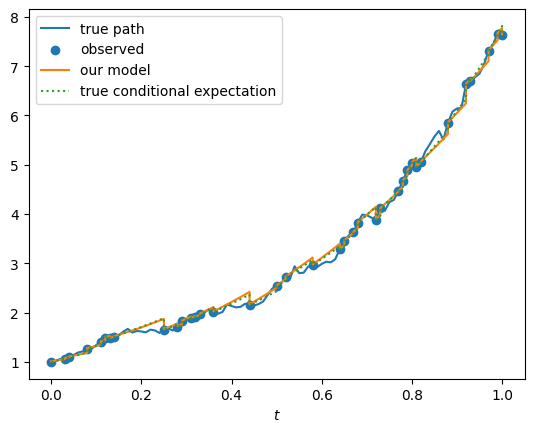

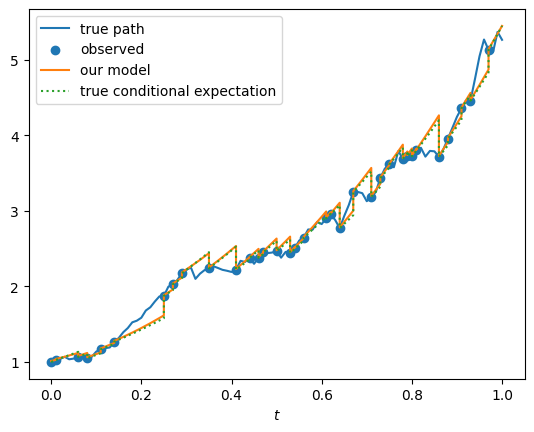

optimal loss (test): 0.03123327290171792
model loss   (test): 0.03514661639928818


plots on test set:


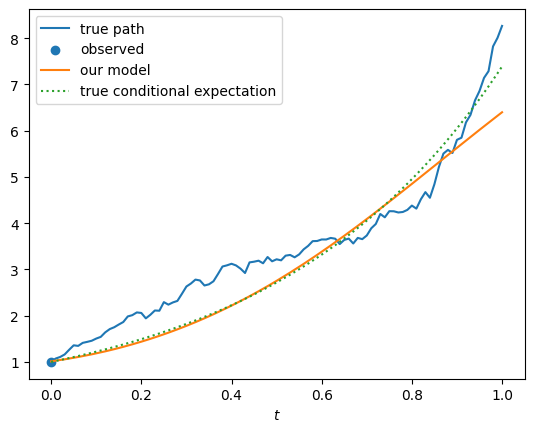

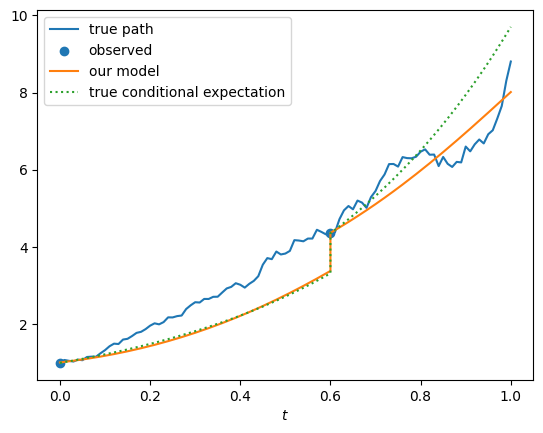

optimal loss (test): 0.27897052814472434
model loss   (test): 0.3038713037967682


In [ ]:
# plotting from validation samples
print("plots on validation set:")
batch = next(iter(results4[3]))
opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=results4[0], batch=batch, stockmodel=results4[-2],
    delta_t=dataset_metadata["dt"], T=dataset_metadata["maturity"],
    path_to_plot=(0,1), reuse_cond_exp=False,
    plot_variance=False, plot_true_var=False,
    which_loss='noisy_obs',)
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

# plotting from test samples
print("\n\nplots on test set:")
batch = next(iter(results4[4]))
opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=results4[0], batch=batch, stockmodel=results4[-1],
    delta_t=dataset_metadata["dt"], T=dataset_metadata["maturity"],
    path_to_plot=(0,1), reuse_cond_exp=False,
    plot_variance=False, plot_true_var=False,
    which_loss='noisy_obs',)
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

As expected, the model learns long term predictions much better than before, while also keeping good short term predictions. Longer training will lead to better results, especially because the probability $p$ descreases slowlier giving the model more time to learn predictions of different time horizon lengths.

## How to handle prediction problems with different input and output processes

---
**References**:
- the paper [10](https://arxiv.org/abs/2412.03271)
---

The NJODE was originally designed to (optimally) predict a process $X_t$ given all past (discrete and possibly incomplete) observations of this process $X$. However, this can be generalised to settings where an input process $U$ is observed (at discrete observation times) and an output process $V$ should be (optimally) predicted.

To do this, two obvious changes of the model framework are needed:
1. The input to the NJODE model should only be the observations of $U$.
2. The output of the NJODE model should only predict the process $V$. In line with this, the loss function will only compare the models prediction $Y$ to the observations of $V$.

However, there is another necessary adaptation, which is more subtle:
3. The design of the loss function has to be changed from an $L^2$-loss with $L^1$ components to a pure $L^2$ loss. In particular, we define the input-output loss function
$$\Psi_{\text{IO}}(\xi, \zeta) := \mathbb{E}\left[ \frac{1}{n} \sum_{i=1}^n   \left\lvert M_i \odot \left( \xi_{t_i} - \zeta_{t_i} \right) \right\rvert_2^2 + \left\lvert M_i \odot \left( \xi_{t_i-} - \zeta_{t_{i}-} \right) \right\rvert_2^2 \right], $$
which squares both terms of the loss individually (instead of squaring their sum, as the standard loss function does).

**Explanation**:
To understand why the change of the loss function is needed, we first consider the case where the the input process equals the output process (or more generally, where all output coordinates are also input coordinates). In this case, the first term of the loss function vanishes for the conditional expectation, since the optimal prediction of the observed coordinates, given this information, are the observed values. Hence, only the second term remains, which is squared and therefore amounts to a $L^2$ objective, which is minimized by the conditional expectation.

In contrast to this, in the general input-output case, where at least one output coordinate is *not* an input coordinate, the first term does not vanish.
Hence, if we square the sum of both terms, there will be a non-vanishing  interaction term in addition to the two terms in $\Psi_{\text{IO}}$ and, in general, the conditional expectation will not be the minimizer of the sum of these 3 terms. On the other hand, it is easy to see that the conditional expectation is the minimizer of $\Psi_{\text{IO}}$, since it minimizes both of its terms individually. Hence, by training the NJODE in the input-output case with the loss function $\Psi_{\text{IO}}$, we have the convergence guarantees that the NJODE output converges to $\hat V = \mathbb E [V_\cdot | A_\cdot]$, where $A_t$ is the sigma algebra with the information of all previous observations $U_{t_i}$, with $t_i \leq t$.

### Using the input-output setting for stochastic filtering

In the following we want to consider a classical stochastic filtering example, where a signal process $V$ should be predicted from an observation process $U$. We use a dataset where $V$ is a BM and $U = V + W$, with another independet BM $W$.

Since this dataset is non-Markovian, we have to use RNNs or signatures in the model to deal with the path dependence.

In [ ]:
IO_BM_Filter_dict = {
    'model_name': "BMFiltering",
    'nb_paths': 10000, 'nb_steps': 100,
    'maturity': 1., 'obs_perc': 0.1,
    'alpha': 1, 'dimension': 2,
    'input_coords': [0], 'output_coords': [1],
    'IO_version': True,
}
dataset = create_dataset(IO_BM_Filter_dict["model_name"], IO_BM_Filter_dict, seed=0)
dataset_metadata = dataset[-2]
seed = 1
test_size = 0.2
train_idx, val_idx = train_test_split(
        np.arange(dataset_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)
data_train = IrregularDataset(dataset, idx=train_idx)
data_val = IrregularDataset(dataset, idx=val_idx)

_nn = ((50, 'relu'),)
param_dict_LT = {
    'seed': 2,
    'data_train': data_train,
    'data_val': data_val,
    'dataset_metadata': dataset_metadata,
    'epochs': 10,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 50,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'IO',
    'use_y_for_ode': False,
    'use_rnn': True,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': False,
}

# results = [model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test]
results = train(**param_dict_LT)


<ipython-input-2-c921796cb2d8>:671: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp[jj, 1] = self.get_mu(jj=jj, which_coord_obs=0)


using loss: IO
neuralODE use input scaling with tanh
use residual network: input_size=1, output_size=50
use residual network: input_size=50, output_size=1

input_coords: [0]
output_coords: [1]
input_size: 1
output_size: 1
signature_coords: [0]
no variance computation
optimal val-loss (achieved by true cond exp): 0.56134
initiate new model ...

model overview:
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=53, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=51, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
  )
) 

# parameters=10451



40it [00:18,  2.12it/s]

evaluating ...


epoch 1, weight=0.50000, train-loss=0.60444, optimal-val-loss=0.56134, val-loss=0.56905, 
evaluation mean square difference (test set): 0.00322
save new best model: last-best-loss: inf, new-best-loss: 0.56905, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:17,  2.34it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=0.53584, optimal-val-loss=0.56134, val-loss=0.56659, 
evaluation mean square difference (test set): 0.00169
save new best model: last-best-loss: 0.56905, new-best-loss: 0.56659, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:16,  2.42it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=0.53113, optimal-val-loss=0.56134, val-loss=0.56318, 
evaluation mean square difference (test set): 0.00065
save new best model: last-best-loss: 0.56659, new-best-loss: 0.56318, epoch: 3
----------------------------------------------------------------------------------------------------


40it [00:17,  2.30it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=0.58761, optimal-val-loss=0.56134, val-loss=0.56199, 
evaluation mean square difference (test set): 0.00036
save new best model: last-best-loss: 0.56318, new-best-loss: 0.56199, epoch: 4
----------------------------------------------------------------------------------------------------


40it [00:16,  2.41it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=0.54705, optimal-val-loss=0.56134, val-loss=0.56998, 
evaluation mean square difference (test set): 0.00231
----------------------------------------------------------------------------------------------------


40it [00:18,  2.12it/s]

evaluating ...


epoch 6, weight=0.50000, train-loss=0.51883, optimal-val-loss=0.56134, val-loss=0.56610, 
evaluation mean square difference (test set): 0.00122
----------------------------------------------------------------------------------------------------


40it [00:16,  2.47it/s]

evaluating ...


epoch 7, weight=0.50000, train-loss=0.66201, optimal-val-loss=0.56134, val-loss=0.56514, 
evaluation mean square difference (test set): 0.00095
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 8, weight=0.50000, train-loss=0.54082, optimal-val-loss=0.56134, val-loss=0.56157, 
evaluation mean square difference (test set): 0.00039
save new best model: last-best-loss: 0.56199, new-best-loss: 0.56157, epoch: 8
----------------------------------------------------------------------------------------------------


40it [00:18,  2.11it/s]

evaluating ...


epoch 9, weight=0.50000, train-loss=0.58529, optimal-val-loss=0.56134, val-loss=0.56495, 
evaluation mean square difference (test set): 0.00091
----------------------------------------------------------------------------------------------------


40it [00:16,  2.41it/s]

evaluating ...


epoch 10, weight=0.50000, train-loss=0.52386, optimal-val-loss=0.56134, val-loss=0.56201, 
evaluation mean square difference (test set): 0.00095
----------------------------------------------------------------------------------------------------


<ipython-input-2-c921796cb2d8>:671: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp[jj, 1] = self.get_mu(jj=jj, which_coord_obs=0)


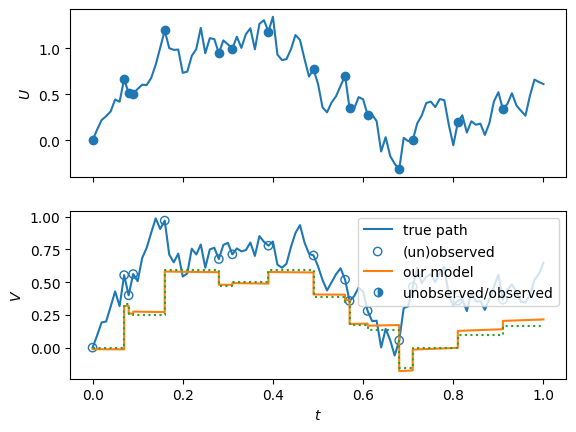

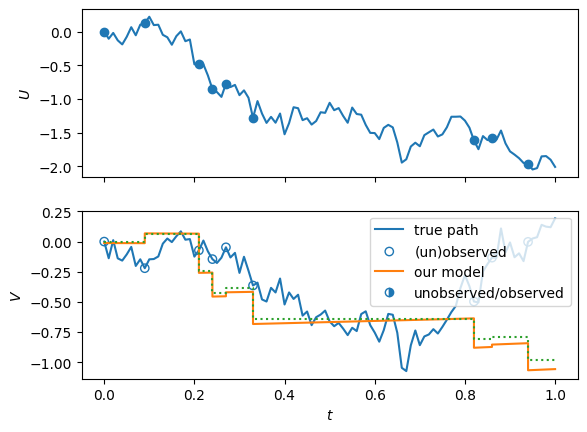

optimal loss (test): 0.5613411664962769
model loss   (test): 0.5620130896568298


In [ ]:
# plotting from test samples
batch = next(iter(results[4]))
opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=results[0], batch=batch, stockmodel=results[-1],
    delta_t=dataset_metadata["dt"], T=dataset_metadata["maturity"],
    path_to_plot=(0,1), reuse_cond_exp=False,
    plot_variance=False, plot_true_var=False,
    which_loss='IO',
    input_coords=[0], output_coords=[1], ylabels=["$U$", "$V$"])
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

We see that the model learns to predict the output process $V$ well from the input process $U$. Longer training will further improve the results.

### **Task**:
Compare the results to those you get when training the NJODE model on the same dataset but with the standard loss function. First predict with arguments of explainability (hard!) what you expect to see and then verify this by training the model.

### When to use the input-output loss function?

The input-output loss function can be used for training on datasets where
the input and the outpt process do not coincide. However, this clearly also involves the case where they do coincide, i.e., the standard setting of the NJODE. Hence, the question arises, whether we should also use the IO loss function in the standard setting, which would make the standard loss function obsolete.



### **Task**

Answer the question first with arguments of explainability.
Then train the same model once with the standard and once with the IO loss function on a dataset where input and output process coincide, to verify your claims.

*Hint:* It can be usefull to consider a specific part of the loss.